In [1]:
import os
import pandas as pd


In [21]:
import os
import pandas as pd

# Use current working directory as base
base_dir = os.getcwd()
folder_path = os.path.join(base_dir, "LOG_RETURNS_KALMAN_INTERPOLATED", "monthly")

log_returns = {}

for file in os.listdir(folder_path):
    if file.endswith(".xlsx"):
        file_path = os.path.join(folder_path, file)
        card_name = file.replace(".xlsx", "")
        log_returns[card_name] = pd.read_excel(file_path)

print(f"Loaded {len(log_returns)} log return datasets.")


Loaded 9 log return datasets.


In [22]:
log_returns.keys()

dict_keys(['monthly_data_aggregated_Charizard-Holo_#11_grade_9', 'monthly_data_aggregated_Charizard-Holo_#4_grade_8_FINAL', 'monthly_data_aggregated_Charizard-Holo_#4_grade_9_FINAL', 'monthly_data_aggregated_Charizard-Reverse_Foil_#11_grade_9', 'monthly_data_aggregated_Full_ArtJessie_&_James_#68_grade_10', 'monthly_data_aggregated_Full_ArtM_Charizard_EX_#101_grade_10', 'monthly_data_aggregated_Red_s_Pikachu_#270_(POKEMON_CENTER_20TH_ANNIVERSARY_CAMPAIGN)_grade_10', 'monthly_data_aggregated_Reshiram_&_Charizard_GX_#20_grade_10', 'monthly_data_aggregated_Venusaur-Holo_#15_grade_9_FINAL'])

In [23]:
# Replace with any dataset name to preview
sample_card = list(log_returns.keys())[0]  # First dataset
print(f"Preview of {sample_card}:")
print(log_returns[sample_card].head())


Preview of monthly_data_aggregated_Charizard-Holo_#11_grade_9:
   Date  Log_Returns
0     1    -0.139010
1     2    -0.523014
2     3    -0.363226
3     4     0.165090
4     5     0.078366


In [24]:
!pip install hurst statsmodels numpy pandas


Defaulting to user installation because normal site-packages is not writeable


In [25]:
!pip install fractional

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for fractional: filename=fractional-0.0.1-py3-none-any.whl size=2514 sha256=0ef7041ef1a40f4f5212cc6bfe6f29fde8297b162caa759188a9a786ba1a726b
  Stored in directory: c:\users\janhr\appdata\local\pip\cache\wheels\19\e8\7a\3ed1246e28624eef16a442cc37483946a8e8e433530a443e7f
Successfully built fractional


In [26]:
!pip install fdiff

Defaulting to user installation because normal site-packages is not writeable


# !! USE THE FOLLOWING TWO HURST EXPONENTS (the most refined so far):

In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.signal import periodogram



def gph_estimator(series, m=None):
    series = series.dropna().values
    n = len(series)

    if m is None:
        m = int(n ** 0.6)  # Slightly higher exponent for robustness

    freqs, spectrum = periodogram(series, scaling='spectrum')

    valid_indices = freqs > 0
    freqs = freqs[valid_indices]
    spectrum = spectrum[valid_indices]

    eps = 1e-10  # Small constant for stability
    log_freqs = np.log(freqs[:m])
    log_spectrum = np.log(spectrum[:m] + eps)

    X = sm.add_constant(-2 * log_freqs)
    model = sm.OLS(log_spectrum, X).fit()

    d = model.params[1] / 2
    hurst_exp = d + 0.5

    return hurst_exp


  # Apply functions to each dataset
hurst_results_gph = {
    card: {
        "Hurst_GPH": gph_estimator(df["Log_Returns"]),

    }
    for card, df in log_returns.items()
}

# Convert to DataFrame for better visualization
hurst_df_gph = pd.DataFrame(hurst_results_gph).T
hurst_df_gph


Hurst_GPH
monthly_data_aggregated_Full_ArtJessie_&_James_...   0.535019
monthly_data_aggregated_Full_ArtM_Charizard_EX_...   0.650737
monthly_data_aggregated_Charizard-Holo_#11_grade_9   0.725738
monthly_data_aggregated_Reshiram_&_Charizard_GX...   0.424688
monthly_data_aggregated_Venusaur-Holo_#15_grade...   0.711170
monthly_data_aggregated_Charizard-Holo_#4_grade...   0.615865
monthly_data_aggregated_Charizard-Holo_#4_grade...   0.564224
monthly_data_aggregated_Charizard-Reverse_Foil_...   0.646469
monthly_data_aggregated_Red's_Pikachu_#270_(POK...   0.604148

In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def local_whittle_estimator(series, m=None):
    series = series.dropna().values  # Remove NaN values
    n = len(series)

    if m is None:
        m = int(n ** 0.8)  # Default bandwidth choice

    # Compute the Fourier frequencies
    freqs = (2 * np.pi * np.arange(1, m + 1)) / n  # Exclude zero frequency

    # Compute the periodogram
    fft_vals = np.fft.fft(series - np.mean(series))  # Demeaned FFT
    periodogram_vals = (np.abs(fft_vals[1:m + 1]) ** 2) / (n / 2)  # Correct normalization

    # Prevent log(0) issues
    eps = 1e-10
    log_freqs = np.log(freqs)
    log_periodogram = np.log(periodogram_vals + eps)  # Avoid log(0) issues

    # OLS regression to estimate d
    X = sm.add_constant(-2 * log_freqs)  # -2 * log(freq) as explanatory variable
    model = sm.OLS(log_periodogram, X).fit()

    d_estimate = model.params[1] / 2  # Estimate of fractional differencing parameter

    hurst_exp = d_estimate + 0.5  # Convert d to Hurst exponent

    return hurst_exp

# Apply function to each Pokémon card dataset
hurst_results_whittle = {
    card: {
        "Hurst_LW": local_whittle_estimator(df["Log_Returns"])  # Apply Local Whittle
    }
    for card, df in log_returns.items()
}

# Convert to DataFrame for better visualization
hurst_df_whittle = pd.DataFrame(hurst_results_whittle).T  # Transpose for readability

hurst_df_whittle


Hurst_LW
monthly_data_aggregated_Full_ArtJessie_&_James_...  0.232604
monthly_data_aggregated_Full_ArtM_Charizard_EX_...  0.471069
monthly_data_aggregated_Charizard-Holo_#11_grade_9  0.391737
monthly_data_aggregated_Reshiram_&_Charizard_GX...  0.335857
monthly_data_aggregated_Venusaur-Holo_#15_grade...  0.486646
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.424427
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.473980
monthly_data_aggregated_Charizard-Reverse_Foil_...  0.457306
monthly_data_aggregated_Red's_Pikachu_#270_(POK...  0.562663

# NOW fractal dimension:

# !! USE THE FOLLOWING FRACTAL DIMENSIONS (the most refined):

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

# **Hall–Wood Fractal Dimension**
def hall_wood_fd(series):
    series = series.dropna().values  # Remove NaN values
    N = len(series)

    if N < 20:  # Skip very short series
        return np.nan

    scales = np.arange(2, min(20, N // 3))  # Use more scales for stability
    log_scales = np.log(scales)
    log_vars = []

    eps = 1e-10  # Small constant to prevent log(0)

    for scale in scales:
        chunks = [series[i:i + scale] for i in range(0, N - scale + 1, scale)]
        chunk_vars = [np.var(chunk) for chunk in chunks if len(chunk) == scale]

        if len(chunk_vars) > 0:
            log_vars.append(np.log(np.mean(chunk_vars) + eps))

    if len(log_vars) < 2:
        return np.nan  # Not enough data points for regression

    log_scales = log_scales[:len(log_vars)]  # Ensure matching lengths
    slope, _, _, _, _ = linregress(log_scales, log_vars)

    return 2 - slope  # Fractal Dimension D

# **Genton Fractal Dimension**
def genton_fd(series):
    series = series.dropna().values  # Remove NaN values
    N = len(series)

    if N < 20:
        return np.nan

    scales = np.arange(2, min(20, N // 3))  # More scales
    log_scales = np.log(scales)
    log_range = []

    eps = 1e-10  # Small constant for stability

    for scale in scales:
        chunks = [series[i:i + scale] for i in range(0, N - scale + 1, scale)]
        chunk_ranges = [np.percentile(chunk, 75) - np.percentile(chunk, 25) for chunk in chunks if len(chunk) == scale]  # Use IQR

        if len(chunk_ranges) > 0:
            log_range.append(np.log(np.mean(chunk_ranges) + eps))

    if len(log_range) < 2:
        return np.nan  # Not enough data points for regression

    log_scales = log_scales[:len(log_range)]  # Ensure matching lengths
    slope, _, _, _, _ = linregress(log_scales, log_range)

    return 2 - slope  # Fractal Dimension D

# **Apply both estimators to all datasets**
fractal_results = {
    card: {
        "Hall_Wood_FD": hall_wood_fd(df["Log_Returns"]),
        "Genton_FD": genton_fd(df["Log_Returns"])
    }
    for card, df in log_returns.items()
}

# Convert to DataFrame for visualization
fractal_df = pd.DataFrame(fractal_results).T
fractal_df


Hall_Wood_FD  Genton_FD
monthly_data_aggregated_Full_ArtJessie_&_James_...      1.791974   1.943319
monthly_data_aggregated_Full_ArtM_Charizard_EX_...      1.758632   1.817517
monthly_data_aggregated_Charizard-Holo_#11_grade_9      1.857317   1.912792
monthly_data_aggregated_Reshiram_&_Charizard_GX...      1.863206   1.805315
monthly_data_aggregated_Venusaur-Holo_#15_grade...      1.878121   1.866516
monthly_data_aggregated_Charizard-Holo_#4_grade...      1.845175   1.893031
monthly_data_aggregated_Charizard-Holo_#4_grade...      1.891009   1.872086
monthly_data_aggregated_Charizard-Reverse_Foil_...      1.941555   1.815142
monthly_data_aggregated_Red's_Pikachu_#270_(POK...      1.670549   1.813097

## very likely skip the following Higuchi:

In [ ]:
import numpy as np
import pandas as pd

# Higuchi Fractal Dimension Function
def higuchi_fd(series, kmax=10):
    series = series.dropna().values  # Remove NaN values
    N = len(series)

    if N < 10:  # Skip very short series
        return np.nan

    k_values = np.arange(1, kmax + 1)
    Lk = np.zeros(len(k_values))

    for i, k in enumerate(k_values):
        Lm_sum = 0
        count = 0  # Keep track of valid calculations

        for m in range(k):
            idx = m + np.arange(0, (N - m) // k) * k  # Ensure correct indexing
            idx_next = idx + 1  # Shifted index

            if max(idx_next) >= N:  # Check if indices are valid
                continue

            Lm = np.sum(np.abs(series[idx] - series[idx_next])) * (N - 1) / (((N - m) // k) * k**2)
            if not np.isnan(Lm) and Lm > 0:
                Lm_sum += Lm
                count += 1

        if count > 0:
            Lk[i] = Lm_sum / count  # Average over valid values
        else:
            Lk[i] = np.nan  # Assign NaN if no valid values

    # Remove NaNs before regression
    valid_indices = ~np.isnan(Lk) & (Lk > 0)
    if np.sum(valid_indices) < 2:  # Need at least 2 valid points
        return np.nan

    log_k = np.log(k_values[valid_indices])
    log_Lk = np.log(Lk[valid_indices])

    # Linear regression
    slope, intercept = np.polyfit(log_k, log_Lk, 1)  # Only two outputs needed
    return -slope  # Higuchi’s Fractal Dimension

# Apply Higuchi FD to each dataset
higuchi_results = {
    card: higuchi_fd(df["Log_Returns"])
    for card, df in log_returns.items()
}

# Convert results to a DataFrame for visualization
higuchi_df = pd.DataFrame.from_dict(higuchi_results, orient="index", columns=["Higuchi_FD"])
print(higuchi_df)


                                                    Higuchi_FD
weekly_data_aggregated_Charizard-Holo_#4_grade_...    1.991680
weekly_data_aggregated_Full_ArtM_Charizard_EX_#...    1.999879
weekly_data_aggregated_Full_ArtCharizard_Vmax_#...    2.009942
weekly_data_aggregated_Full_ArtMoltres_&_Zapdos...    1.996250
weekly_data_aggregated_Full_ArtCharizard_Vmax_#...    2.030195
weekly_data_aggregated_Charizard_GX_#9_grade_10       1.998054
weekly_data_aggregated_Full_ArtCharizard_GX_#SV...    1.986419
weekly_data_aggregated_Charizard-Holo_#11_grade_9     1.995265
weekly_data_aggregated_Charizard-Holo_#4_grade_...    1.999507


In [ ]:
!pip install nolds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
import nolds
import numpy as np
import pandas as pd

# Function to compute DFA exponent
def compute_dfa(series):
    series = series.dropna().values  # Remove NaN values
    if len(series) < 10:  # Ensure enough data points
        return np.nan
    return nolds.dfa(series)

# Apply DFA to each dataset
dfa_results = {
    card: compute_dfa(df["Log_Returns"])
    for card, df in log_returns.items()
}

# Convert to DataFrame for visualization
dfa_df = pd.DataFrame.from_dict(dfa_results, orient="index", columns=["DFA_Exponent"])

# Display results
print(dfa_df)


                                                    DFA_Exponent
weekly_data_aggregated_Charizard-Holo_#4_grade_...      0.287766
weekly_data_aggregated_Full_ArtM_Charizard_EX_#...      0.218252
weekly_data_aggregated_Full_ArtCharizard_Vmax_#...      0.330509
weekly_data_aggregated_Full_ArtMoltres_&_Zapdos...      0.179798
weekly_data_aggregated_Full_ArtCharizard_Vmax_#...      0.273844
weekly_data_aggregated_Charizard_GX_#9_grade_10         0.189587
weekly_data_aggregated_Full_ArtCharizard_GX_#SV...      0.418152
weekly_data_aggregated_Charizard-Holo_#11_grade_9       0.193486
weekly_data_aggregated_Charizard-Holo_#4_grade_...      0.304980


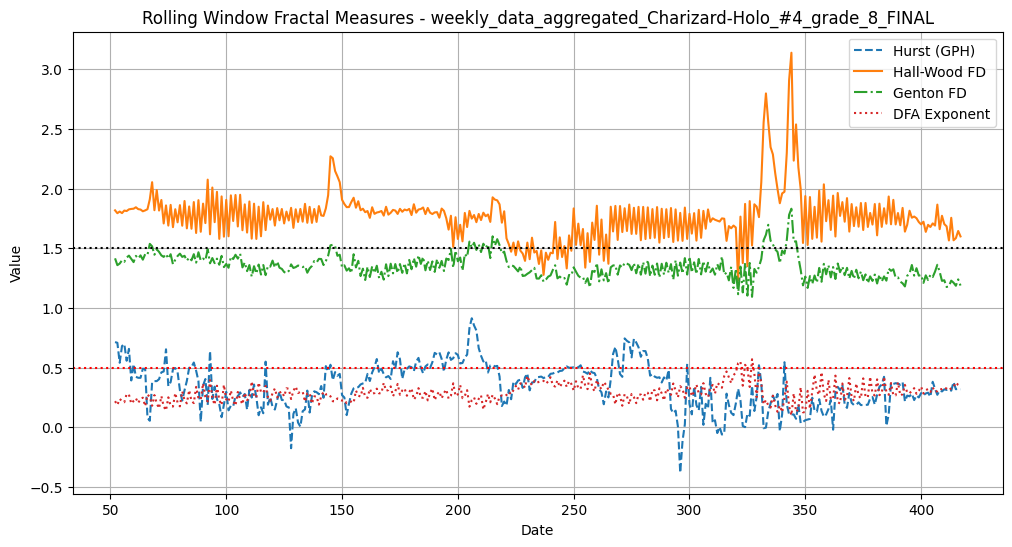

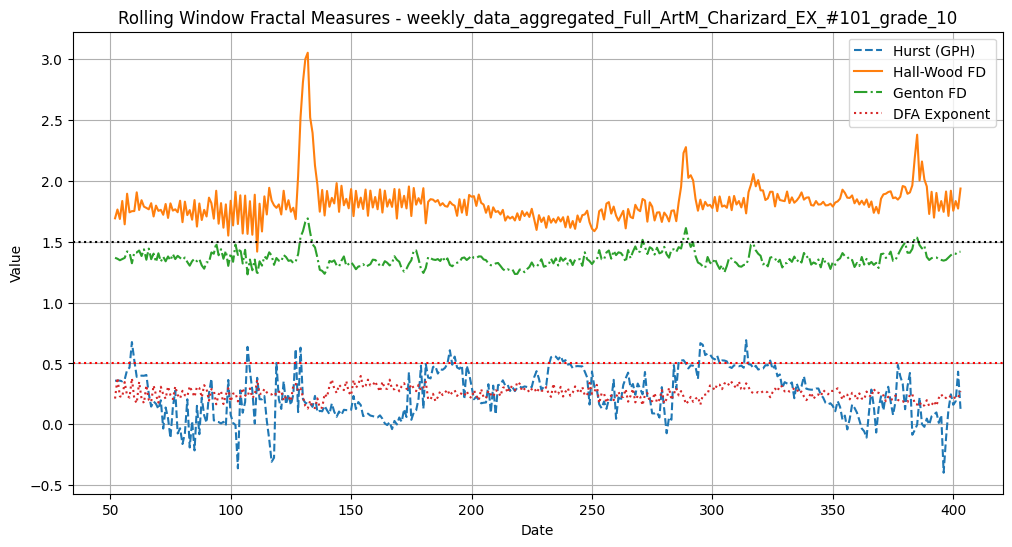

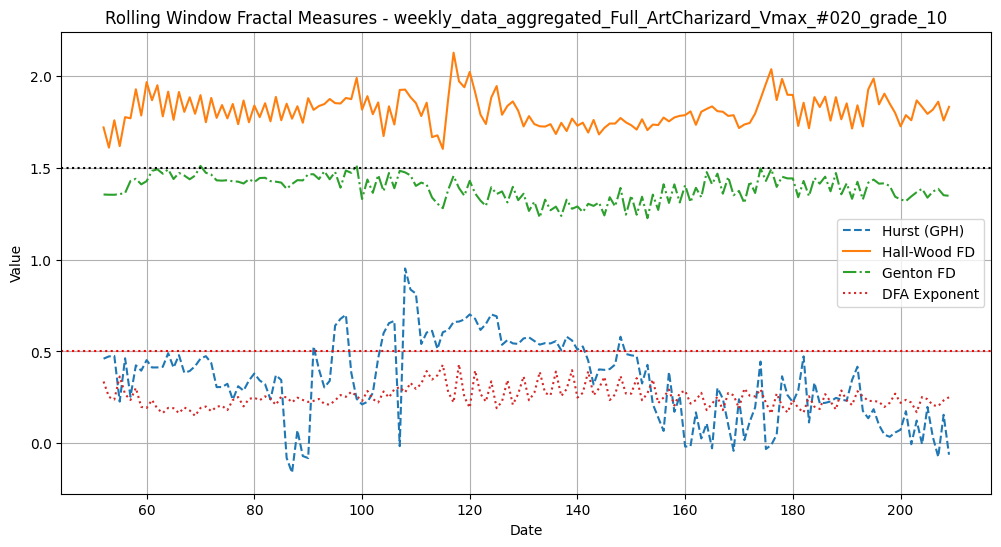

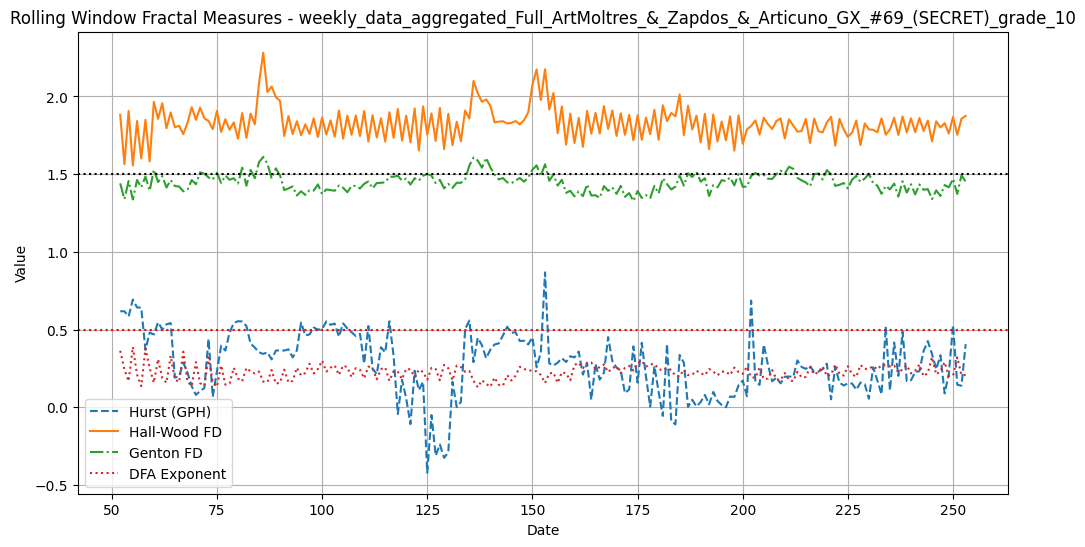

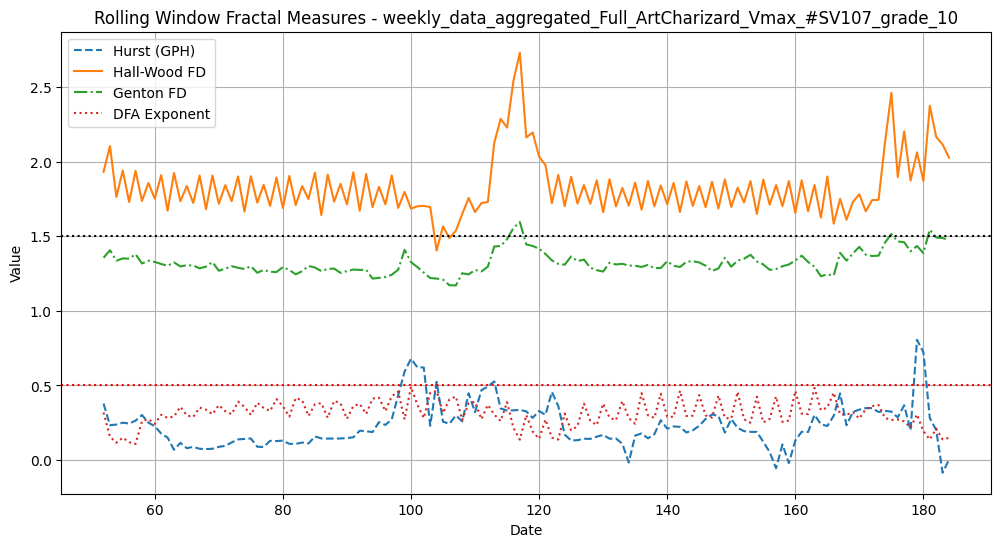

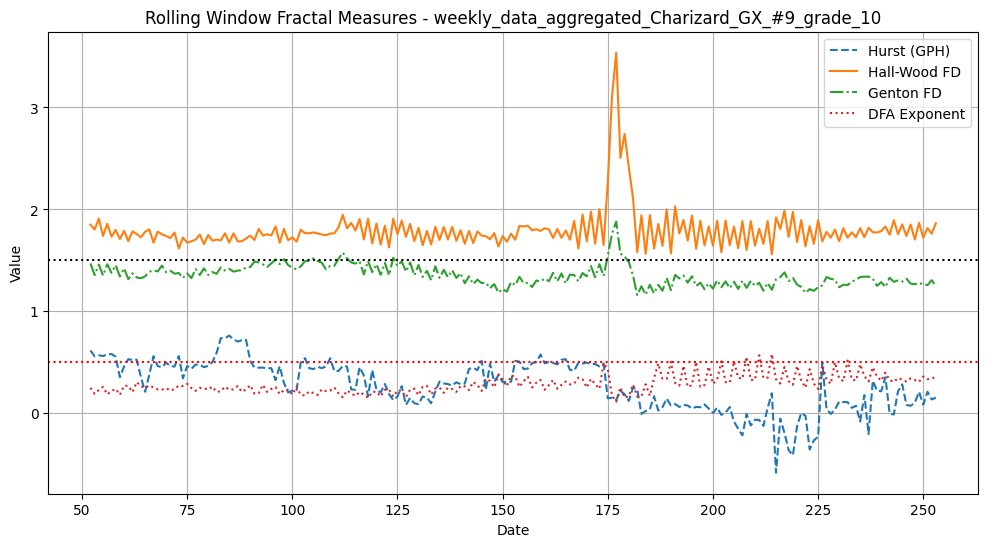

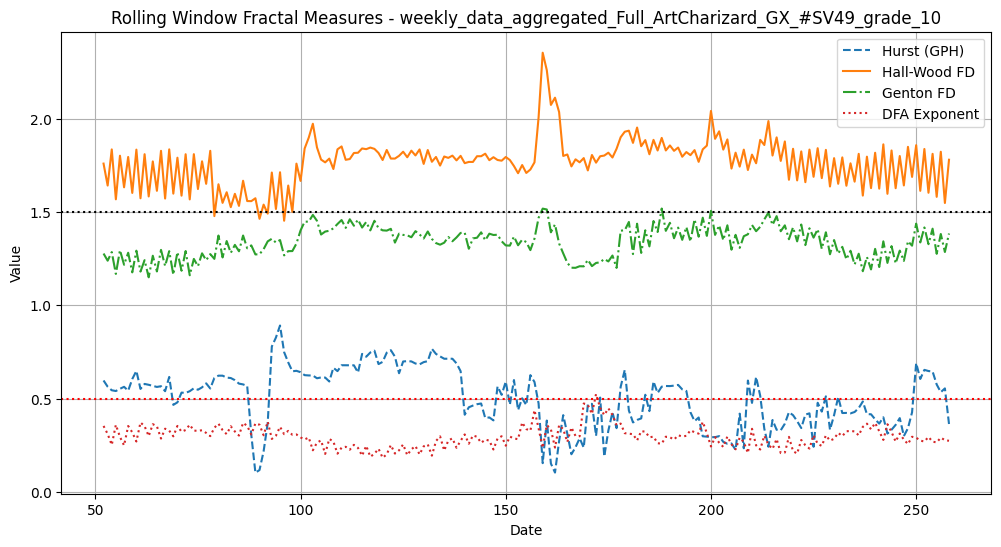

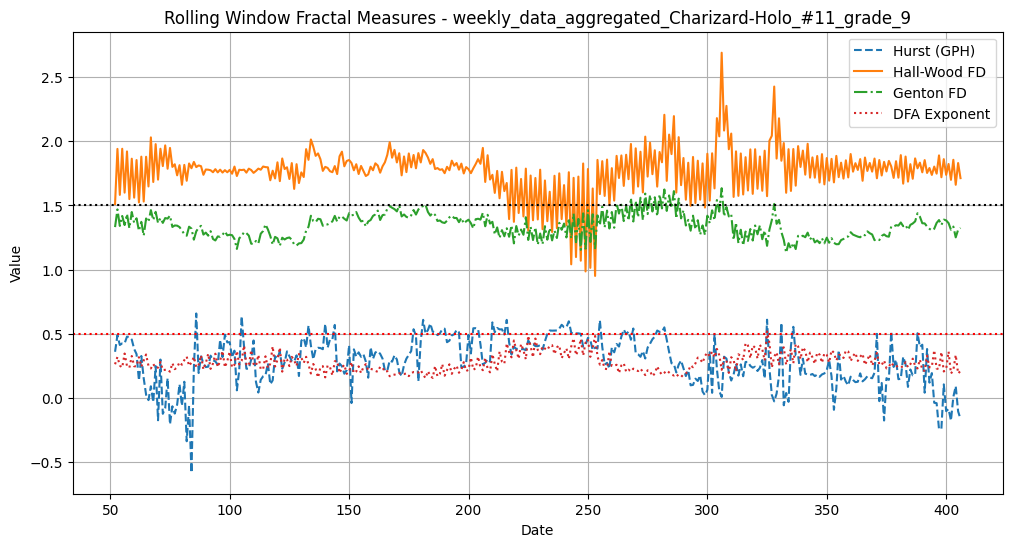

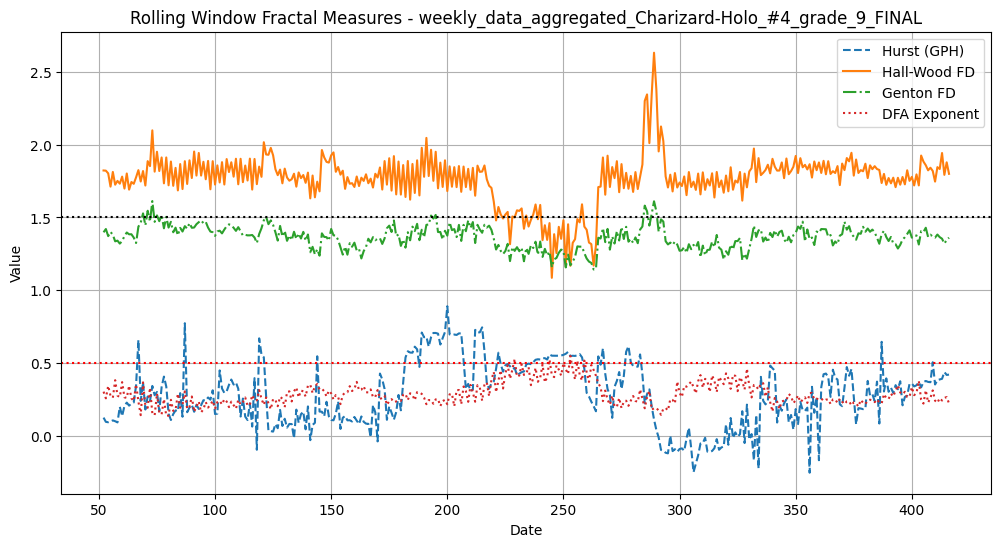

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.signal import periodogram
import matplotlib.pyplot as plt

# Rolling window size (adjust based on data frequency)
ROLLING_WINDOW = 52  # Example: 52 weeks if data is weekly

# Function for GPH Estimator (Rolling)
def gph_estimator(series):
    series = series[~np.isnan(series)]  # Remove NaNs
    if len(series) < 10: return np.nan  # Skip short series

    m = int(np.sqrt(len(series)))
    freqs, spectrum = periodogram(series, scaling='density')

    selected_freqs, selected_spectrum = freqs[1:m+1], spectrum[1:m+1]
    if len(selected_freqs) < 2: return np.nan

    log_freqs, log_spectrum = np.log(selected_freqs), np.log(selected_spectrum)
    X = sm.add_constant(-2 * log_freqs)
    model = sm.OLS(log_spectrum, X).fit()
    d = model.params[1] / 2
    return d + 0.5  # Convert d to Hurst exponent

# Function for Hall–Wood Fractal Dimension (Rolling)
def hall_wood_fd(series):
    series = series[~np.isnan(series)]
    if len(series) < 10: return np.nan

    scales = np.arange(2, min(10, len(series) // 2))
    log_scales = np.log(scales)
    log_vars = []

    for scale in scales:
        chunks = [series[i:i+scale] for i in range(0, len(series)-scale, scale)]
        if len(chunks) > 0:
            log_vars.append(np.log(np.mean([np.var(chunk) for chunk in chunks])))

    if len(log_vars) < 2: return np.nan

    slope, _, _, _, _ = linregress(log_scales[:len(log_vars)], log_vars)
    return 2 - slope

# Function for Genton Fractal Dimension (Rolling)
def genton_fd(series):
    series = series[~np.isnan(series)]
    if len(series) < 10: return np.nan

    scales = np.arange(2, min(10, len(series) // 2))
    log_scales = np.log(scales)
    log_range = []

    for scale in scales:
        chunks = [series[i:i+scale] for i in range(0, len(series)-scale, scale)]
        if len(chunks) > 0:
            log_range.append(np.log(np.mean([np.ptp(chunk) for chunk in chunks])))

    if len(log_range) < 2: return np.nan

    slope, _, _, _, _ = linregress(log_scales[:len(log_range)], log_range)
    return 2 - slope

# Function for DFA Exponent (Rolling)
def dfa_exponent(series):
    series = series[~np.isnan(series)]
    if len(series) < 10: return np.nan

    scales = np.unique(np.logspace(0.5, np.log10(len(series)//2), num=10, dtype=int))
    flucts = []

    for scale in scales:
        n_segments = len(series) // scale
        if n_segments < 2: return np.nan

        rms_vals = []
        for i in range(n_segments):
            seg = series[i * scale:(i + 1) * scale]
            if len(seg) < scale:
                continue
            x = np.arange(scale)
            coeffs = np.polyfit(x, seg, 1)
            trend = np.polyval(coeffs, x)
            rms_vals.append(np.sqrt(np.mean((seg - trend) ** 2)))

        flucts.append(np.mean(rms_vals))

    if len(flucts) < 2: return np.nan

    slope, _, _, _, _ = linregress(np.log(scales[:len(flucts)]), np.log(flucts))
    return slope  # DFA exponent

# **Apply rolling window analysis to all datasets**
rolling_results = {}

for card, df in log_returns.items():
    df = df.dropna().reset_index(drop=True)  # Ensure clean indexing

    rolling_results[card] = pd.DataFrame({
        "Date": df["Date"].iloc[ROLLING_WINDOW-1:],  # Align dates with rolling estimates
        "Hurst_GPH": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: gph_estimator(x), raw=False),
        "Hall_Wood_FD": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: hall_wood_fd(x), raw=False),
        "Genton_FD": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: genton_fd(x), raw=False),
        "DFA_Exponent": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: dfa_exponent(x), raw=False),
    }).dropna()  # Drop NaN values

# **Plotting all cards**
for card, df in rolling_results.items():
    plt.figure(figsize=(12, 6))

    plt.plot(df["Date"], df["Hurst_GPH"], label="Hurst (GPH)", linestyle="dashed")
    plt.plot(df["Date"], df["Hall_Wood_FD"], label="Hall-Wood FD", linestyle="solid")
    plt.plot(df["Date"], df["Genton_FD"], label="Genton FD", linestyle="dashdot")
    plt.plot(df["Date"], df["DFA_Exponent"], label="DFA Exponent", linestyle="dotted")

    plt.axhline(y=1.5, color="black", linestyle="dotted")  # Efficiency threshold for FD
    plt.axhline(y=0.5, color="red", linestyle="dotted")  # Efficiency threshold for Hurst

    plt.title(f"Rolling Window Fractal Measures - {card}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()


# !! USE THE FOLLOWING ONLY FOR THE APPROX. ENTROPY:

In [15]:
import numpy as np
import pandas as pd

# Function to compute Approximate Entropy (ApEn)
def approximate_entropy(series, m=2, r=None):
    series = series.dropna().values  # Remove NaNs
    N = len(series)

    eps = 1e-10  # Small constant for numerical stability

    if N < m + 1:
        return np.nan  # Not enough data

    if r is None:
        r = 0.2 * np.std(series)  # Set default tolerance

    # Create patterns
    patterns_m = np.array([series[i:i + m] for i in range(N - m + 1)])
    patterns_m1 = np.array([series[i:i + m + 1] for i in range(N - m)])

    def phi(patterns):
        distances = np.abs(patterns[:, None, :] - patterns[None, :, :]).max(axis=2)
        C = np.sum(distances <= r, axis=1) / (N - len(patterns) + 1)
        return np.mean(np.log(C + eps))  # Prevent log(0) errors

    return abs(phi(patterns_m) - phi(patterns_m1))  # ApEn formula

# **Apply to all datasets**
approx_entropy_results = {
    card: approximate_entropy(df["Log_Returns"])
    for card, df in log_returns.items()
}

# Convert to DataFrame for better visualization
approx_entropy_df = pd.DataFrame.from_dict(approx_entropy_results, orient="index", columns=["Approx_Entropy"])

approx_entropy_df


Approx_Entropy
monthly_data_aggregated_Full_ArtJessie_&_James_...        1.278124
monthly_data_aggregated_Full_ArtM_Charizard_EX_...        1.132805
monthly_data_aggregated_Charizard-Holo_#11_grade_9        1.146083
monthly_data_aggregated_Reshiram_&_Charizard_GX...        0.861378
monthly_data_aggregated_Venusaur-Holo_#15_grade...        1.116615
monthly_data_aggregated_Charizard-Holo_#4_grade...        1.051609
monthly_data_aggregated_Charizard-Holo_#4_grade...        1.172723
monthly_data_aggregated_Charizard-Reverse_Foil_...        1.079883
monthly_data_aggregated_Red's_Pikachu_#270_(POK...        1.026561

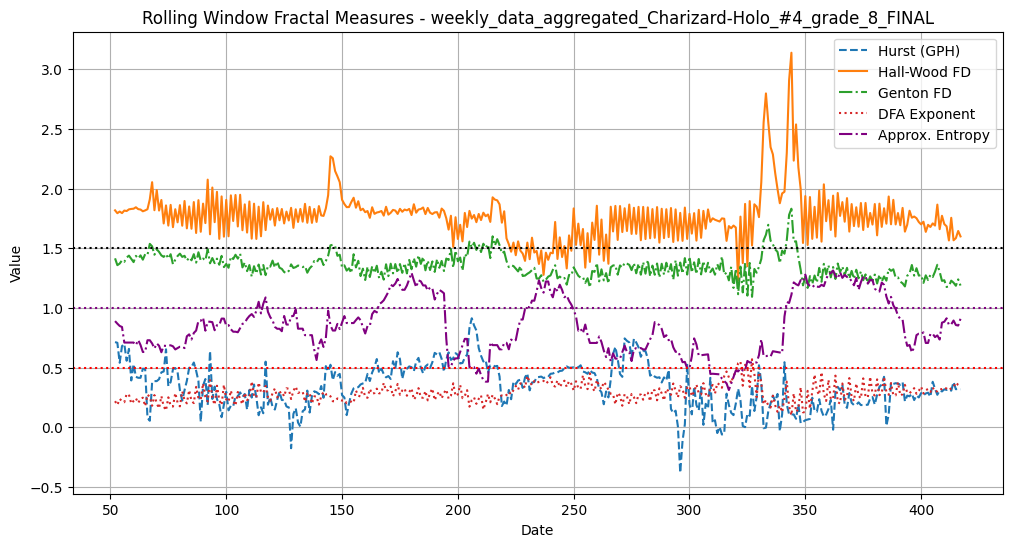

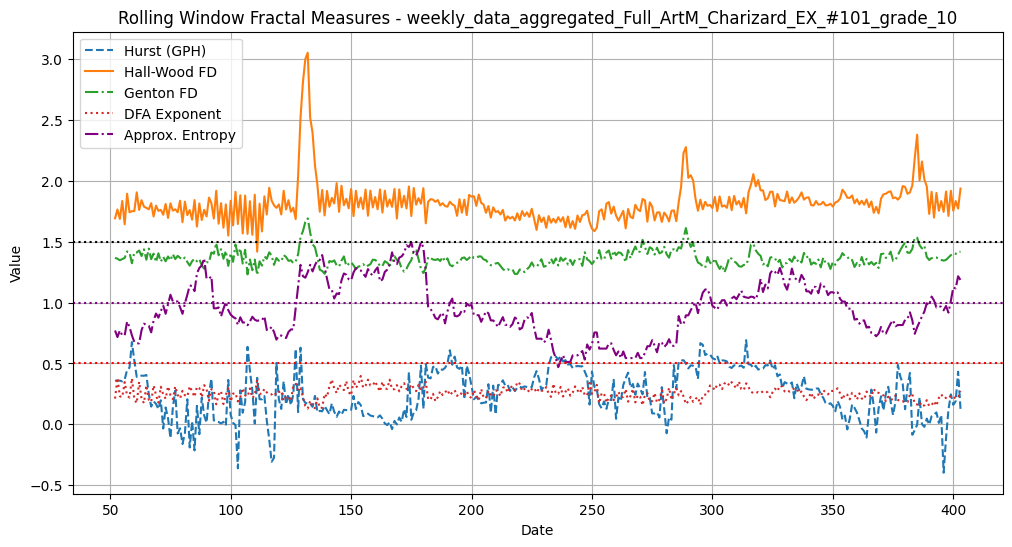

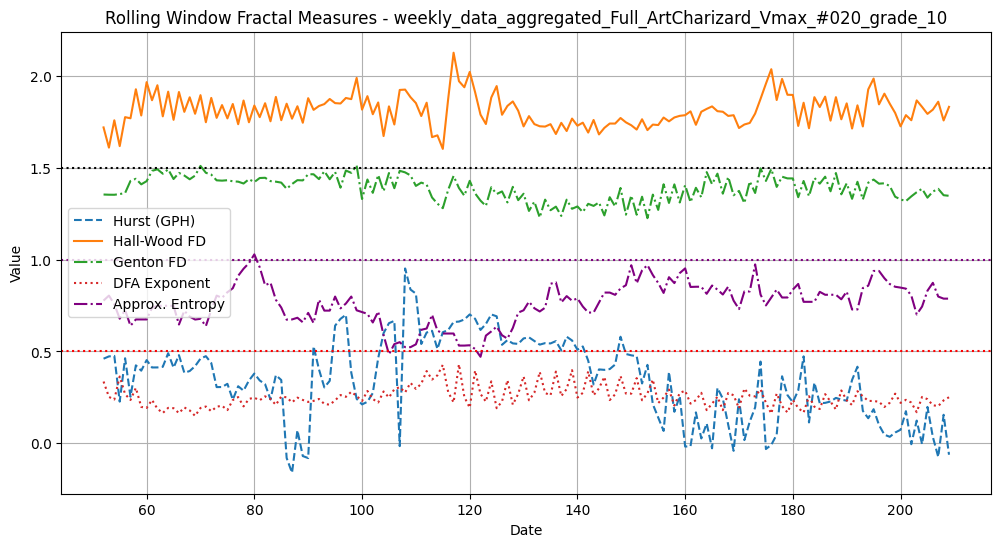

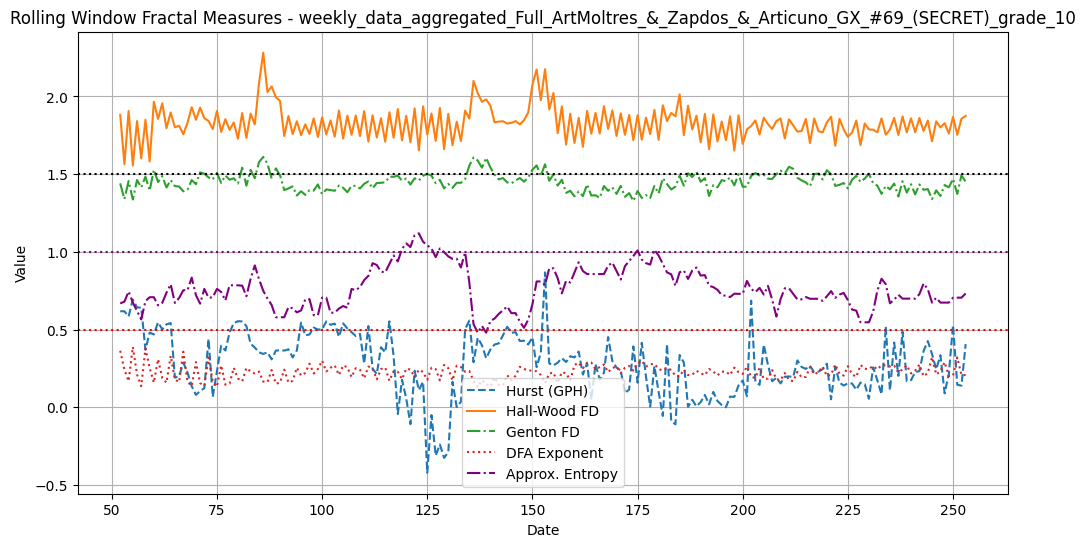

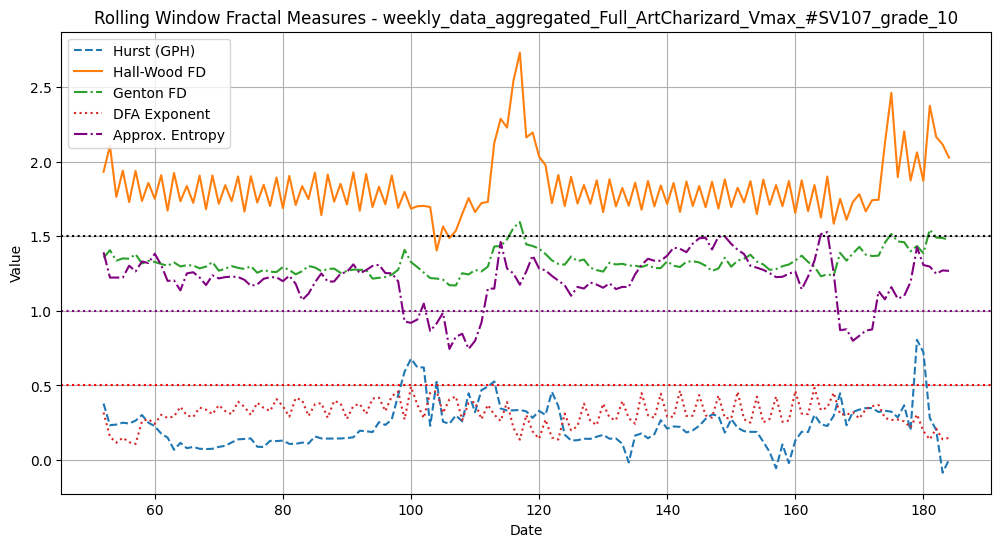

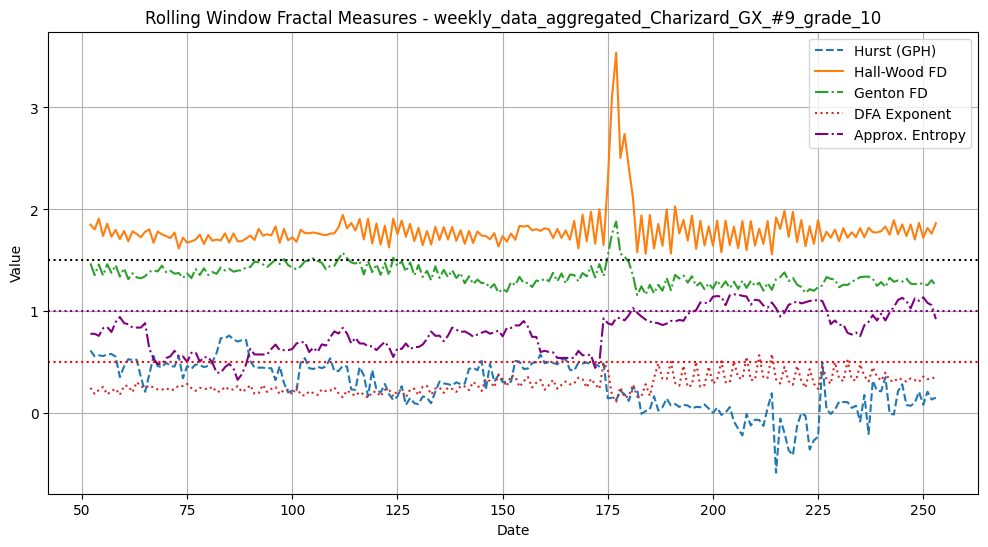

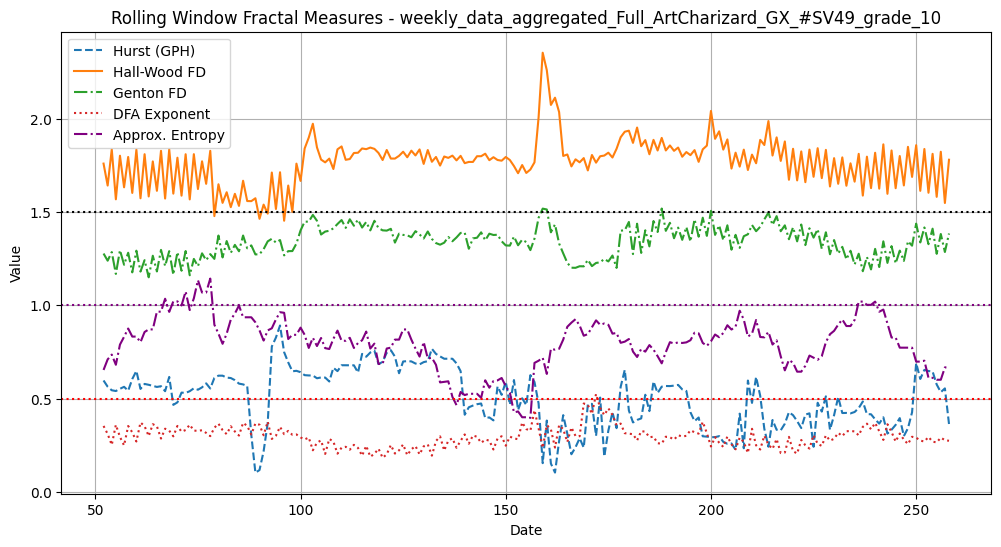

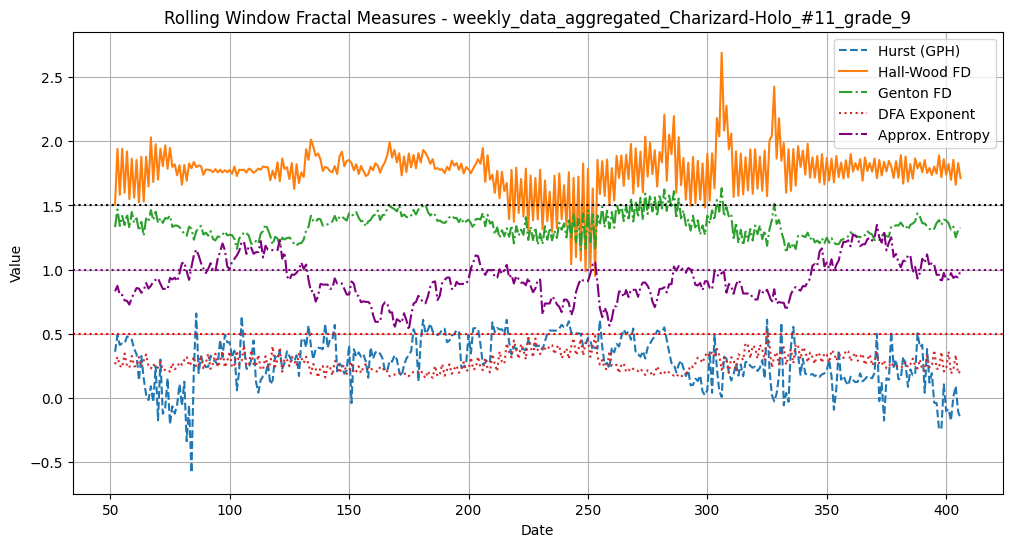

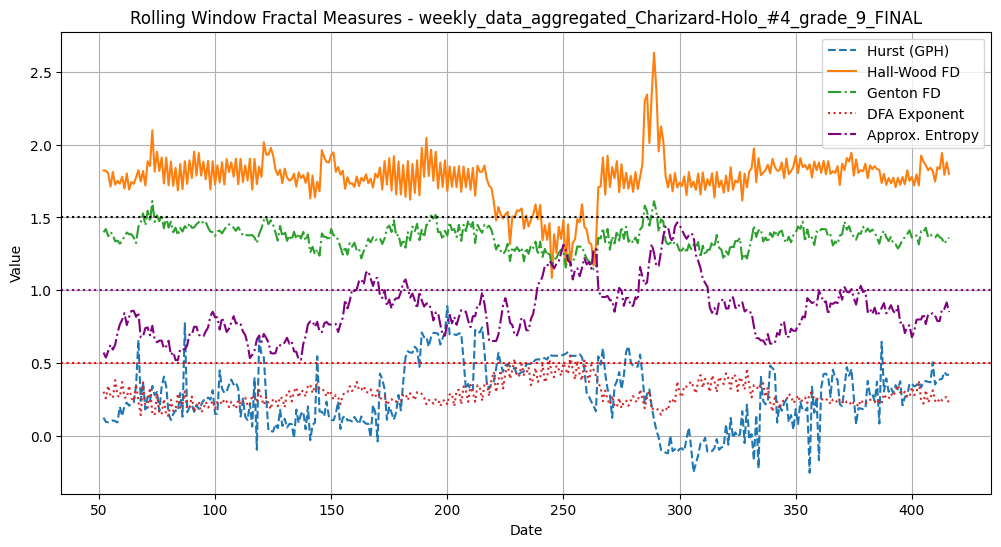

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.signal import periodogram
import matplotlib.pyplot as plt

# Rolling window size (adjust based on data frequency)
ROLLING_WINDOW = 52  # Example: 52 weeks if data is weekly

# **Approximate Entropy Function**
def approximate_entropy(series, m=2, r=None):
    series = series.dropna().values  # Remove NaNs
    N = len(series)
    if N < m + 1:
        return np.nan

    if r is None:
        r = 0.2 * np.std(series)  # Standard choice in literature

    def phi(m):
        patterns = np.array([series[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.abs(patterns[:, None] - patterns).max(axis=2) <= r, axis=1) / (N - m + 1)
        return np.sum(np.log(C)) / (N - m + 1)

    return phi(m) - phi(m + 1)

# **GPH Estimator (Hurst Exponent)**
def gph_estimator(series):
    series = series[~np.isnan(series)]
    if len(series) < 10:
        return np.nan

    m = int(np.sqrt(len(series)))
    freqs, spectrum = periodogram(series, scaling='density')

    selected_freqs, selected_spectrum = freqs[1:m+1], spectrum[1:m+1]
    if len(selected_freqs) < 2:
        return np.nan

    log_freqs, log_spectrum = np.log(selected_freqs), np.log(selected_spectrum)
    X = sm.add_constant(-2 * log_freqs)
    model = sm.OLS(log_spectrum, X).fit()
    d = model.params[1] / 2
    return d + 0.5  # Convert d to Hurst exponent

# **Fractal Dimension Functions (Hall-Wood & Genton)**
def hall_wood_fd(series):
    series = series[~np.isnan(series)]
    if len(series) < 10:
        return np.nan

    scales = np.arange(2, min(10, len(series) // 2))
    log_scales = np.log(scales)
    log_vars = []

    for scale in scales:
        chunks = [series[i:i+scale] for i in range(0, len(series)-scale, scale)]
        if len(chunks) > 0:
            log_vars.append(np.log(np.mean([np.var(chunk) for chunk in chunks])))

    if len(log_vars) < 2:
        return np.nan

    slope, _, _, _, _ = linregress(log_scales[:len(log_vars)], log_vars)
    return 2 - slope

def genton_fd(series):
    series = series[~np.isnan(series)]
    if len(series) < 10:
        return np.nan

    scales = np.arange(2, min(10, len(series) // 2))
    log_scales = np.log(scales)
    log_range = []

    for scale in scales:
        chunks = [series[i:i+scale] for i in range(0, len(series)-scale, scale)]
        if len(chunks) > 0:
            log_range.append(np.log(np.mean([np.ptp(chunk) for chunk in chunks])))

    if len(log_range) < 2:
        return np.nan

    slope, _, _, _, _ = linregress(log_scales[:len(log_range)], log_range)
    return 2 - slope

# **DFA Exponent Function**
def dfa_exponent(series):
    series = series[~np.isnan(series)]
    if len(series) < 10:
        return np.nan

    scales = np.unique(np.logspace(0.5, np.log10(len(series)//2), num=10, dtype=int))
    flucts = []

    for scale in scales:
        n_segments = len(series) // scale
        if n_segments < 2:
            return np.nan

        rms_vals = []
        for i in range(n_segments):
            seg = series[i * scale:(i + 1) * scale]
            if len(seg) < scale:
                continue
            x = np.arange(scale)
            coeffs = np.polyfit(x, seg, 1)
            trend = np.polyval(coeffs, x)
            rms_vals.append(np.sqrt(np.mean((seg - trend) ** 2)))

        flucts.append(np.mean(rms_vals))

    if len(flucts) < 2:
        return np.nan

    slope, _, _, _, _ = linregress(np.log(scales[:len(flucts)]), np.log(flucts))
    return slope  # DFA exponent

# **Apply rolling window analysis to all datasets**
rolling_results = {}

for card, df in log_returns.items():
    df = df.dropna().reset_index(drop=True)  # Ensure clean indexing

    rolling_results[card] = pd.DataFrame({
        "Date": df["Date"].iloc[ROLLING_WINDOW-1:],  # Align dates with rolling estimates
        "Hurst_GPH": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: gph_estimator(x), raw=False),
        "Hall_Wood_FD": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: hall_wood_fd(x), raw=False),
        "Genton_FD": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: genton_fd(x), raw=False),
        "DFA_Exponent": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: dfa_exponent(x), raw=False),
        "Approx_Entropy": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: approximate_entropy(x), raw=False) * 2,  # **Scaling Fix Applied**,
    }).dropna()  # Drop NaN values

# **Plotting all cards with Approximate Entropy**
for card, df in rolling_results.items():
    plt.figure(figsize=(12, 6))

    plt.plot(df["Date"], df["Hurst_GPH"], label="Hurst (GPH)", linestyle="dashed")
    plt.plot(df["Date"], df["Hall_Wood_FD"], label="Hall-Wood FD", linestyle="solid")
    plt.plot(df["Date"], df["Genton_FD"], label="Genton FD", linestyle="dashdot")
    plt.plot(df["Date"], df["DFA_Exponent"], label="DFA Exponent", linestyle="dotted")
    plt.plot(df["Date"], df["Approx_Entropy"], label="Approx. Entropy", linestyle="dashdot", color="purple")

    plt.axhline(y=1.5, color="black", linestyle="dotted")  # Efficiency threshold for FD
    plt.axhline(y=0.5, color="red", linestyle="dotted")  # Efficiency threshold for Hurst
    plt.axhline(y=1, color="purple", linestyle="dotted")  # Efficiency threshold for Approx. Entropy

    plt.title(f"Rolling Window Fractal Measures - {card}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()


# ... for the approximate entropy idk what is the correct scale - above its multiplied by two since before it was as below (seems too low but idk..:):

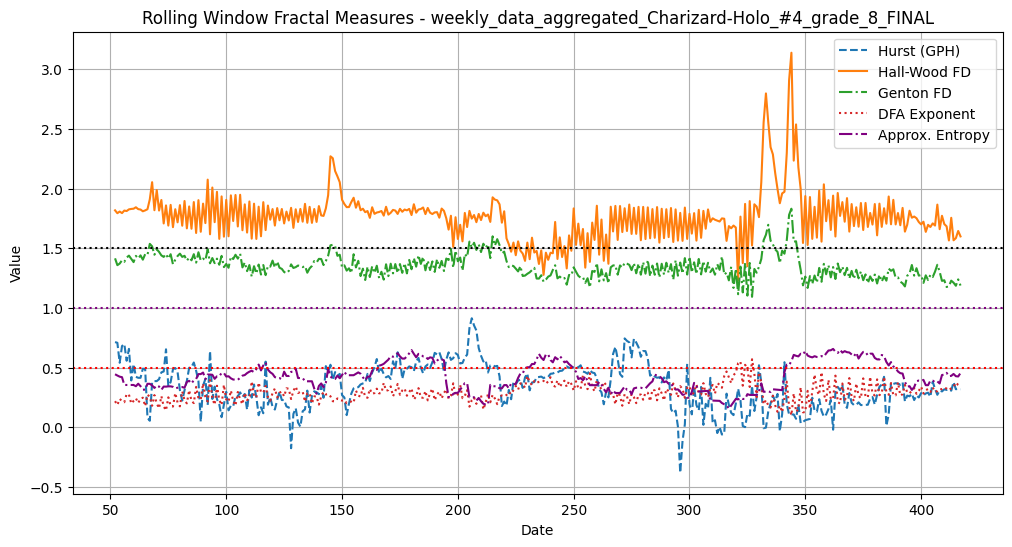

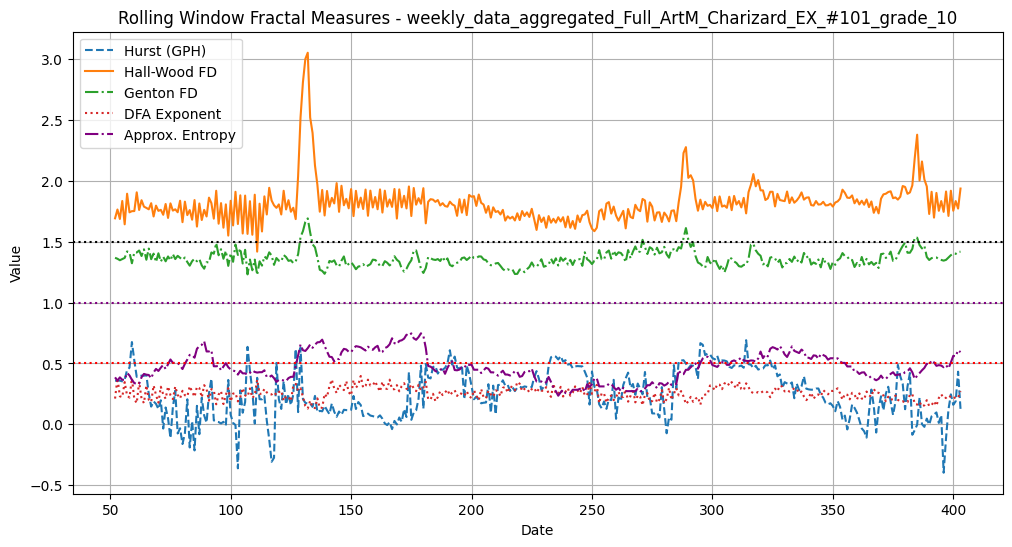

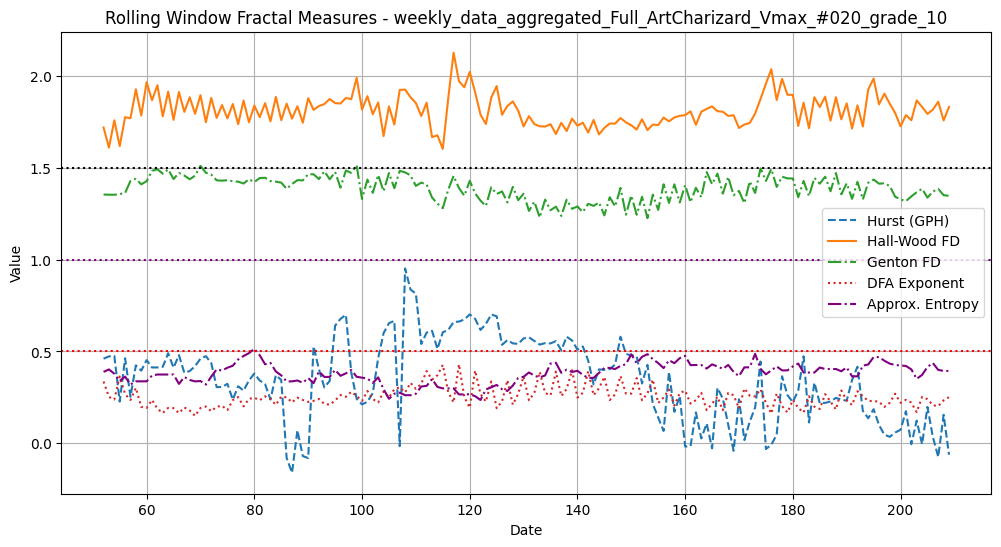

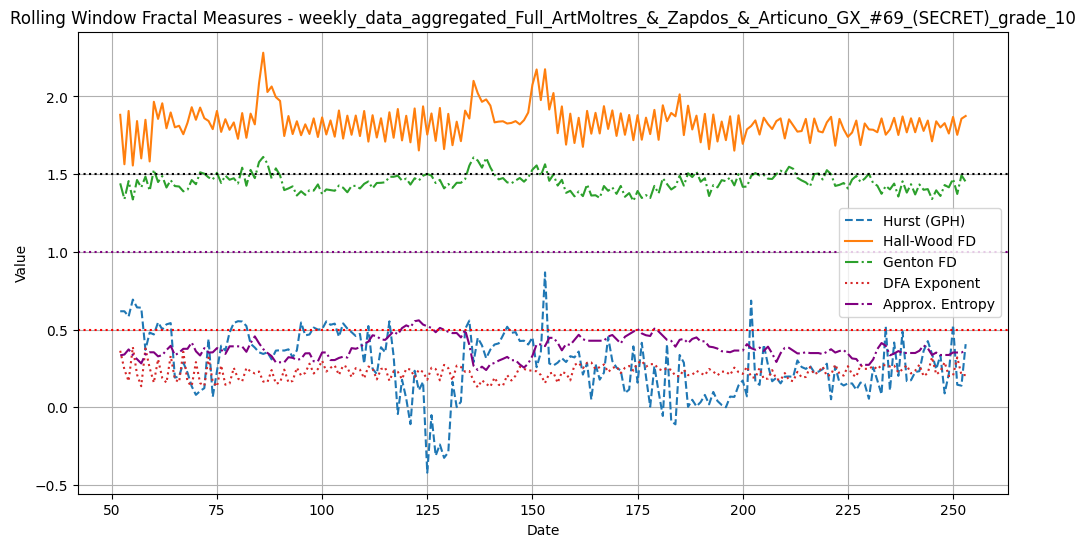

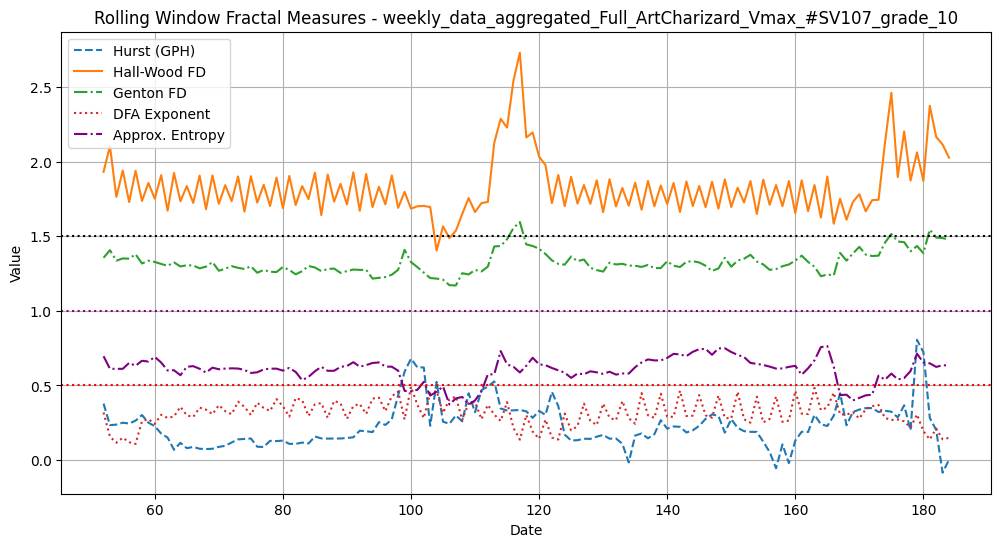

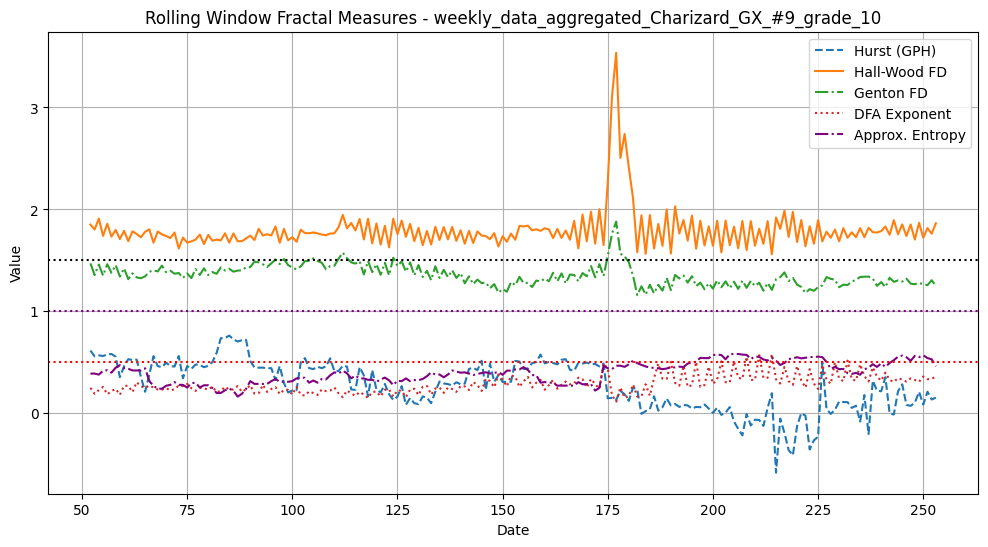

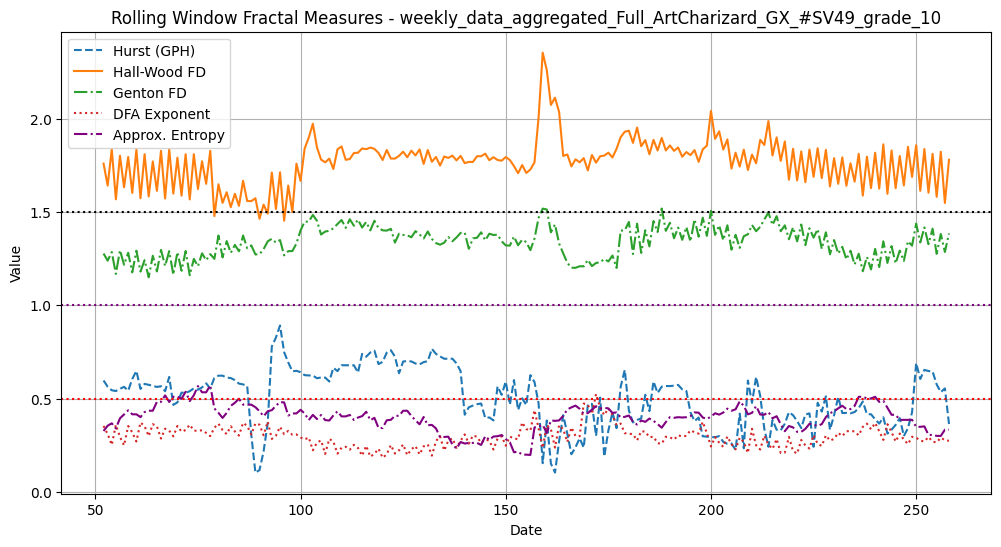

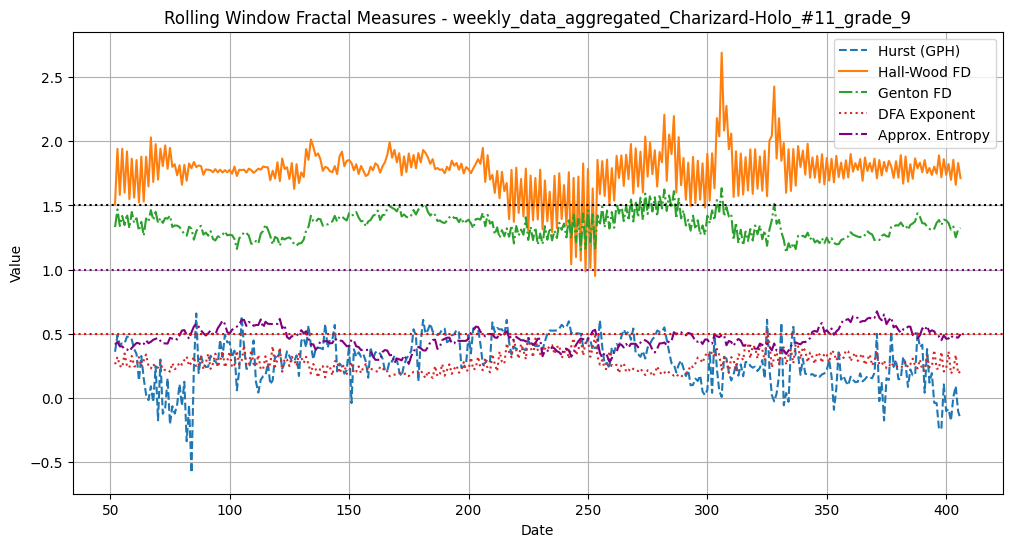

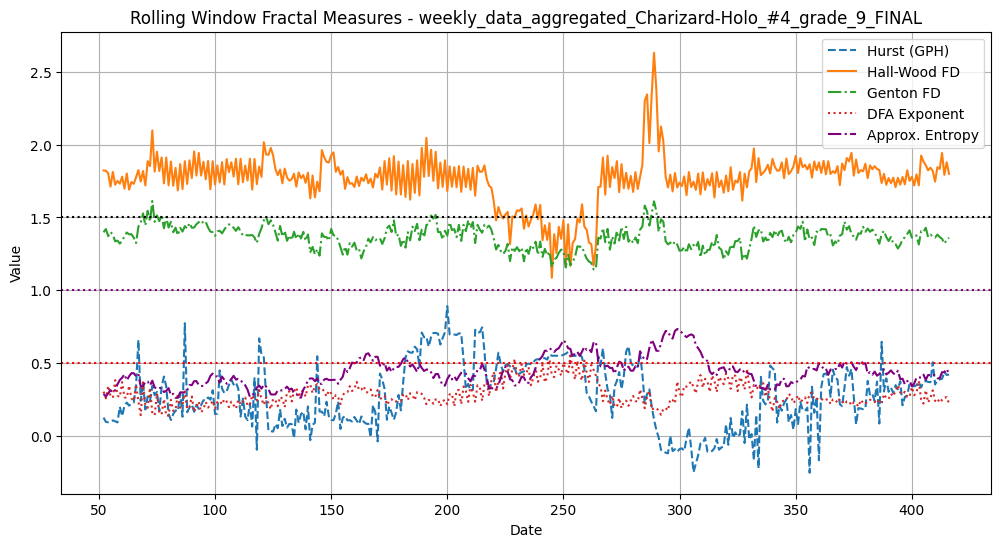

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.signal import periodogram
import matplotlib.pyplot as plt

# Rolling window size (adjust based on data frequency)
ROLLING_WINDOW = 52  # Example: 52 weeks if data is weekly

# **Approximate Entropy Function**
def approximate_entropy(series, m=2, r=None):
    series = series.dropna().values  # Remove NaNs
    N = len(series)
    if N < m + 1:
        return np.nan

    if r is None:
        r = 0.2 * np.std(series)  # Standard choice in literature

    def phi(m):
        patterns = np.array([series[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.abs(patterns[:, None] - patterns).max(axis=2) <= r, axis=1) / (N - m + 1)
        return np.sum(np.log(C)) / (N - m + 1)

    return phi(m) - phi(m + 1)

# **GPH Estimator (Hurst Exponent)**
def gph_estimator(series):
    series = series[~np.isnan(series)]
    if len(series) < 10:
        return np.nan

    m = int(np.sqrt(len(series)))
    freqs, spectrum = periodogram(series, scaling='density')

    selected_freqs, selected_spectrum = freqs[1:m+1], spectrum[1:m+1]
    if len(selected_freqs) < 2:
        return np.nan

    log_freqs, log_spectrum = np.log(selected_freqs), np.log(selected_spectrum)
    X = sm.add_constant(-2 * log_freqs)
    model = sm.OLS(log_spectrum, X).fit()
    d = model.params[1] / 2
    return d + 0.5  # Convert d to Hurst exponent

# **Fractal Dimension Functions (Hall-Wood & Genton)**
def hall_wood_fd(series):
    series = series[~np.isnan(series)]
    if len(series) < 10:
        return np.nan

    scales = np.arange(2, min(10, len(series) // 2))
    log_scales = np.log(scales)
    log_vars = []

    for scale in scales:
        chunks = [series[i:i+scale] for i in range(0, len(series)-scale, scale)]
        if len(chunks) > 0:
            log_vars.append(np.log(np.mean([np.var(chunk) for chunk in chunks])))

    if len(log_vars) < 2:
        return np.nan

    slope, _, _, _, _ = linregress(log_scales[:len(log_vars)], log_vars)
    return 2 - slope

def genton_fd(series):
    series = series[~np.isnan(series)]
    if len(series) < 10:
        return np.nan

    scales = np.arange(2, min(10, len(series) // 2))
    log_scales = np.log(scales)
    log_range = []

    for scale in scales:
        chunks = [series[i:i+scale] for i in range(0, len(series)-scale, scale)]
        if len(chunks) > 0:
            log_range.append(np.log(np.mean([np.ptp(chunk) for chunk in chunks])))

    if len(log_range) < 2:
        return np.nan

    slope, _, _, _, _ = linregress(log_scales[:len(log_range)], log_range)
    return 2 - slope

# **DFA Exponent Function**
def dfa_exponent(series):
    series = series[~np.isnan(series)]
    if len(series) < 10:
        return np.nan

    scales = np.unique(np.logspace(0.5, np.log10(len(series)//2), num=10, dtype=int))
    flucts = []

    for scale in scales:
        n_segments = len(series) // scale
        if n_segments < 2:
            return np.nan

        rms_vals = []
        for i in range(n_segments):
            seg = series[i * scale:(i + 1) * scale]
            if len(seg) < scale:
                continue
            x = np.arange(scale)
            coeffs = np.polyfit(x, seg, 1)
            trend = np.polyval(coeffs, x)
            rms_vals.append(np.sqrt(np.mean((seg - trend) ** 2)))

        flucts.append(np.mean(rms_vals))

    if len(flucts) < 2:
        return np.nan

    slope, _, _, _, _ = linregress(np.log(scales[:len(flucts)]), np.log(flucts))
    return slope  # DFA exponent



# **Approximate Entropy (Rolling)**
def rolling_approximate_entropy(series, window=52, m=2):
    """Computes Approximate Entropy using a rolling window."""
    entropy_values = []

    for i in range(len(series) - window + 1):
        window_data = series.iloc[i : i + window].dropna()
        entropy_values.append(approximate_entropy(window_data, m=m))

    return pd.Series(entropy_values, index=series.index[window - 1:])


# **Apply rolling window analysis to all datasets**
rolling_results = {}

for card, df in log_returns.items():
    df = df.dropna().reset_index(drop=True)  # Ensure clean indexing

    rolling_results[card] = pd.DataFrame({
        "Date": df["Date"].iloc[ROLLING_WINDOW-1:],  # Align dates with rolling estimates
        "Hurst_GPH": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: gph_estimator(x), raw=False),
        "Hall_Wood_FD": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: hall_wood_fd(x), raw=False),
        "Genton_FD": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: genton_fd(x), raw=False),
        "DFA_Exponent": df["Log_Returns"].rolling(ROLLING_WINDOW).apply(lambda x: dfa_exponent(x), raw=False),
        "Approx_Entropy": rolling_approximate_entropy(df["Log_Returns"], window=ROLLING_WINDOW),
    }).dropna()  # Drop NaN values

# **Plotting all cards with Approximate Entropy**
for card, df in rolling_results.items():
    plt.figure(figsize=(12, 6))

    plt.plot(df["Date"], df["Hurst_GPH"], label="Hurst (GPH)", linestyle="dashed")
    plt.plot(df["Date"], df["Hall_Wood_FD"], label="Hall-Wood FD", linestyle="solid")
    plt.plot(df["Date"], df["Genton_FD"], label="Genton FD", linestyle="dashdot")
    plt.plot(df["Date"], df["DFA_Exponent"], label="DFA Exponent", linestyle="dotted")
    plt.plot(df["Date"], df["Approx_Entropy"], label="Approx. Entropy", linestyle="dashdot", color="purple")

    plt.axhline(y=1.5, color="black", linestyle="dotted")  # Efficiency threshold for FD
    plt.axhline(y=0.5, color="red", linestyle="dotted")  # Efficiency threshold for Hurst
    plt.axhline(y=1, color="purple", linestyle="dotted")  # Corrected threshold for Approx. Entropy

    plt.title(f"Rolling Window Fractal Measures - {card}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()


## Rolling Window:

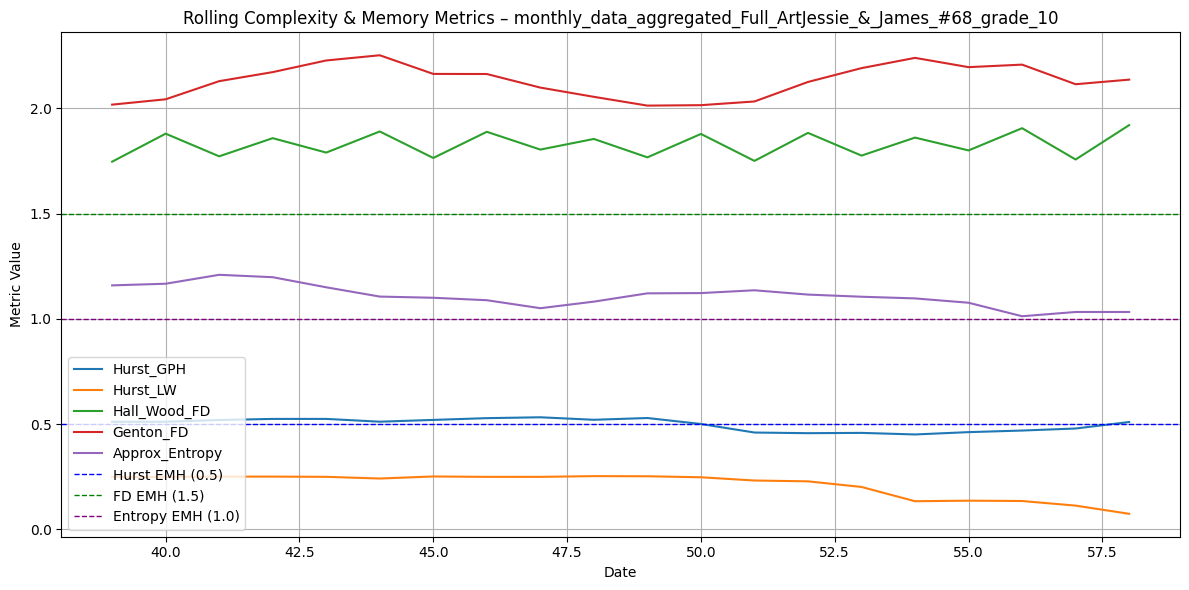

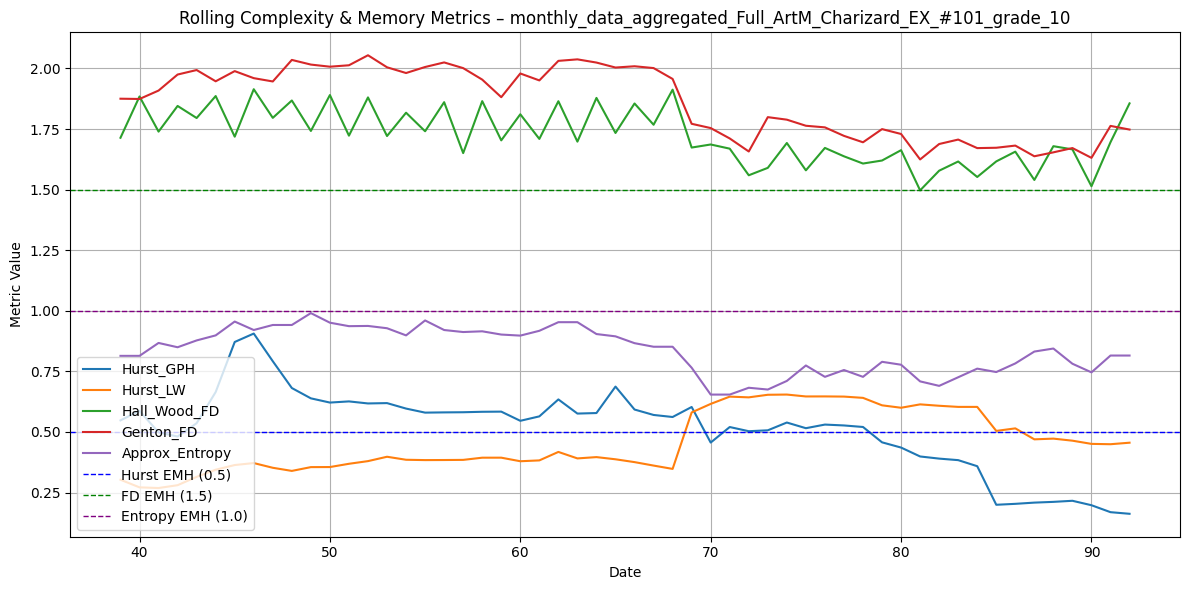

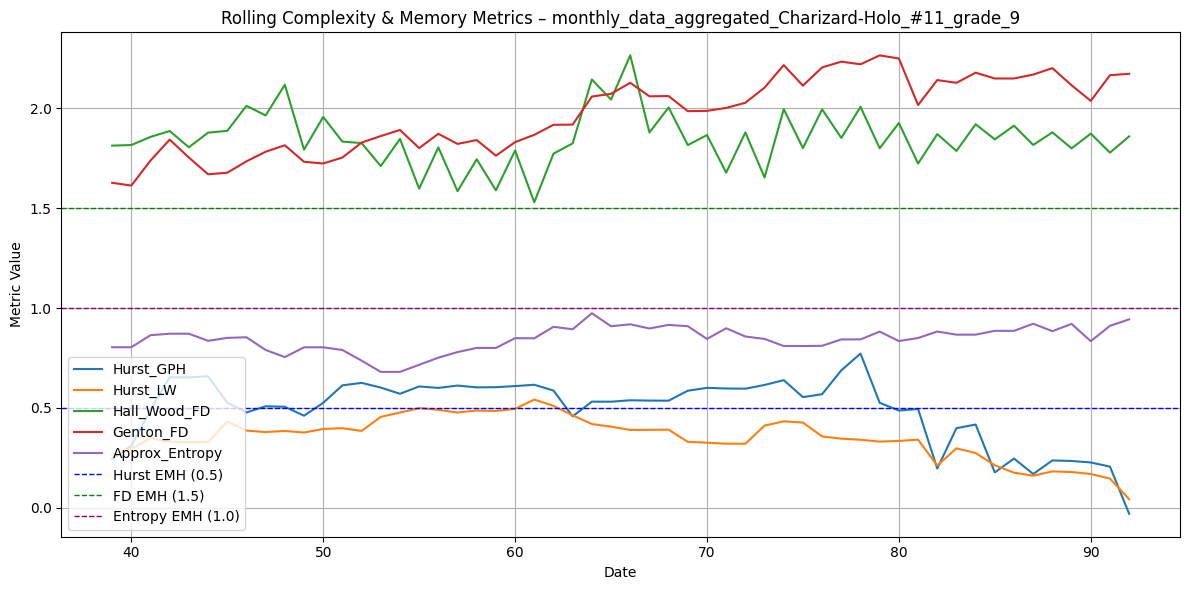

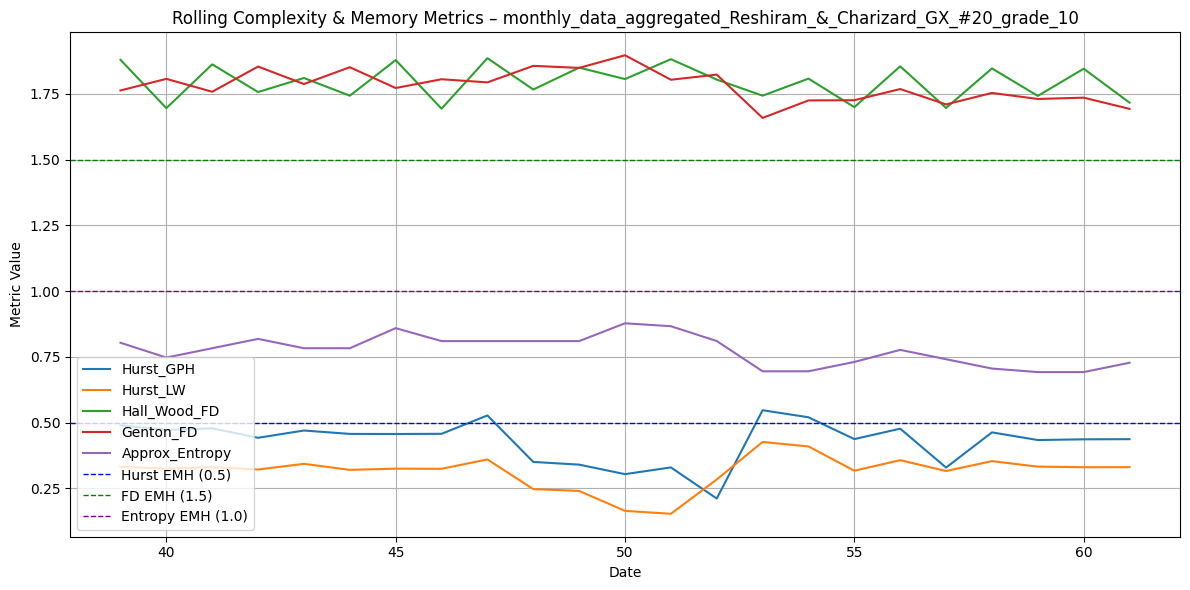

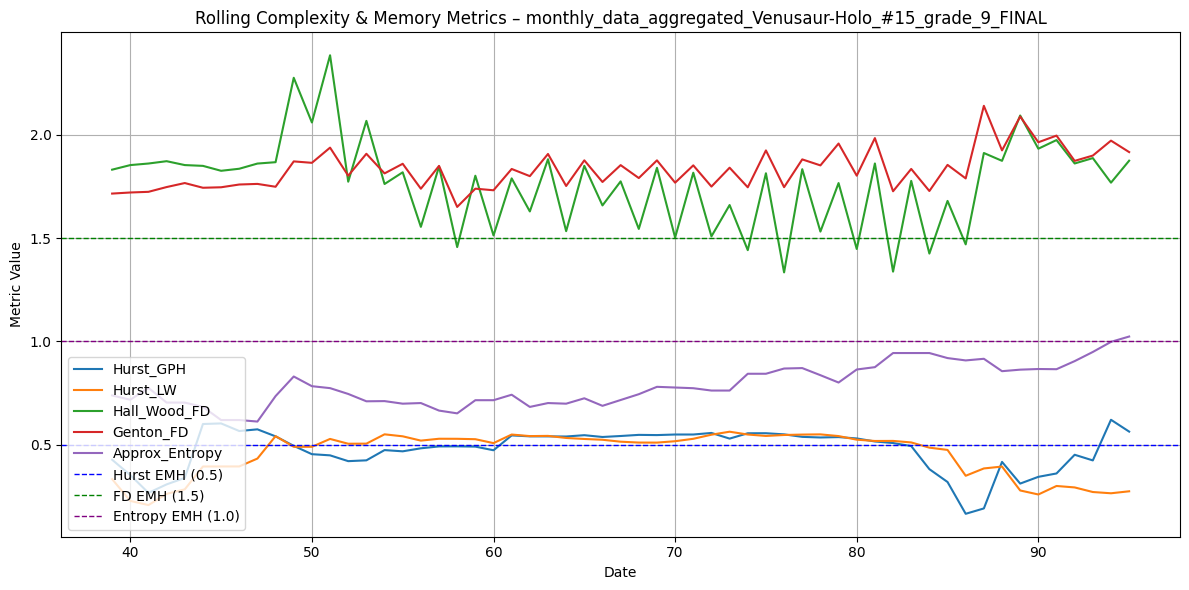

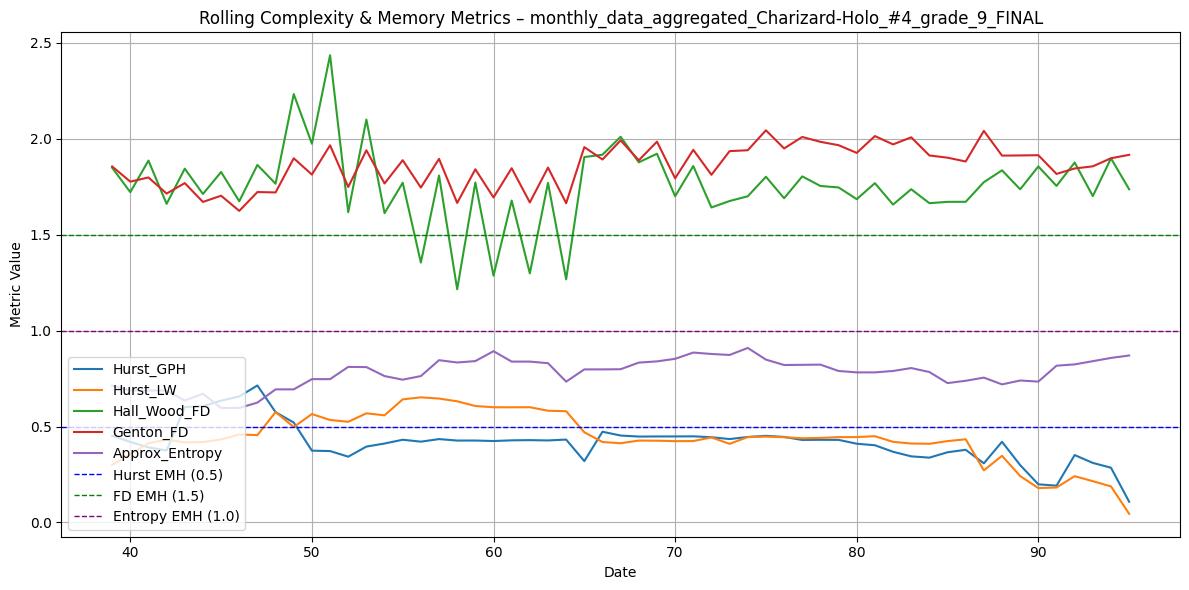

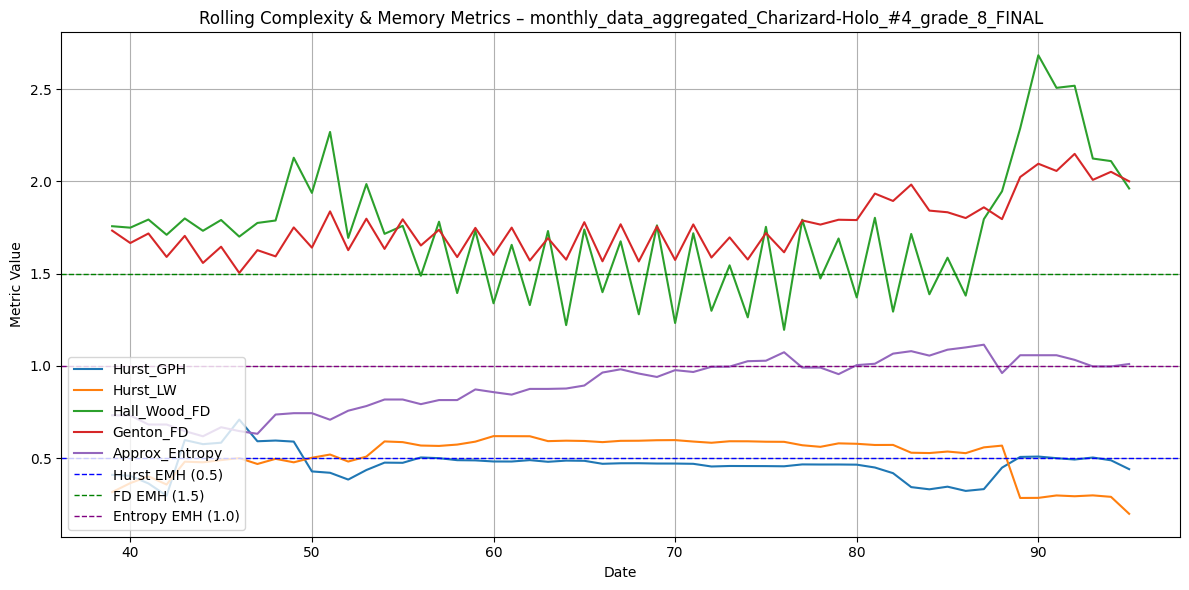

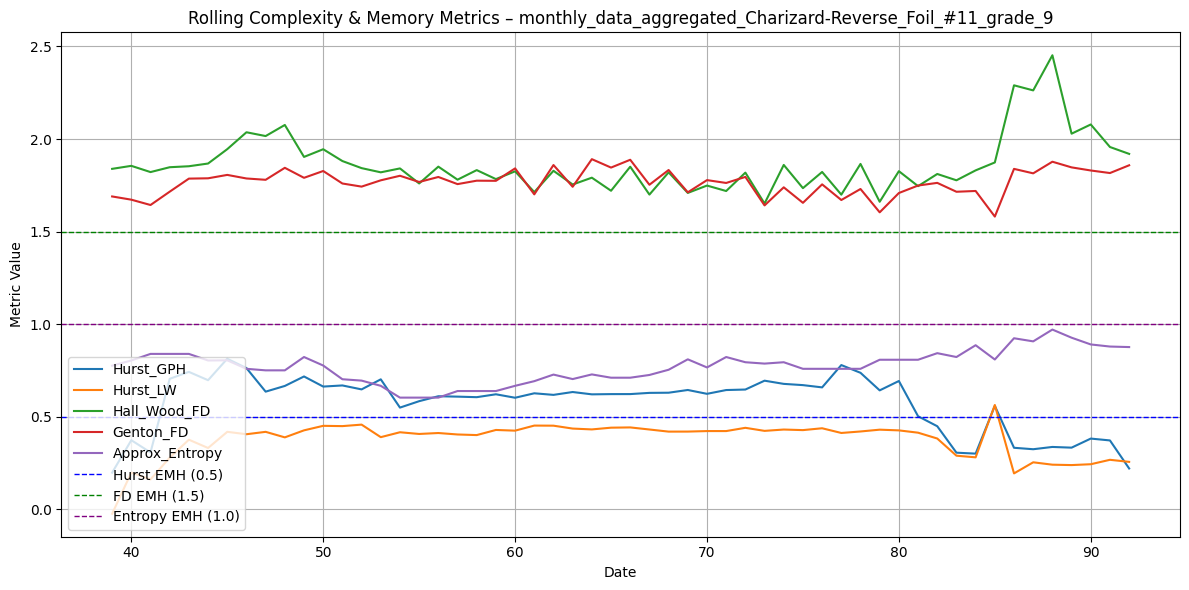

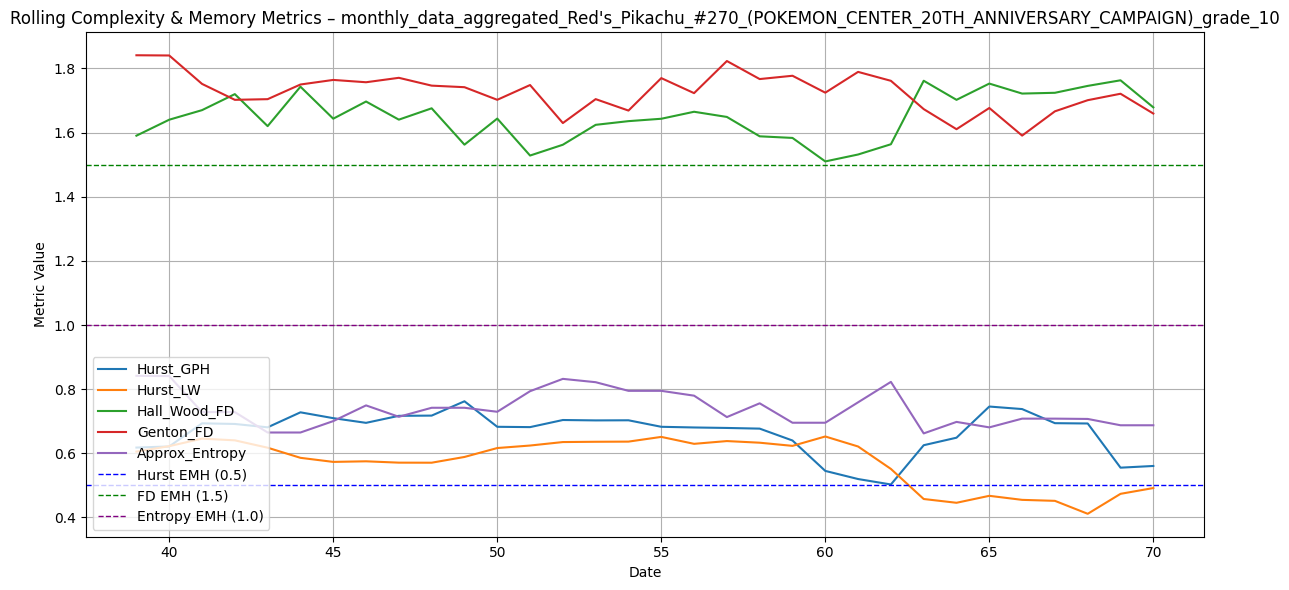

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_rolling_metrics(log_returns, window_size=60, step=5, visualize=False, selected_cards=None):
    card_metrics_over_time = []

    for card, df in log_returns.items():
        series = df["Log_Returns"].dropna().values
        dates = df["Log_Returns"].dropna().index

        if len(series) < window_size:
            continue  # Skip short series

        for i in range(0, len(series) - window_size + 1, step):
            window = series[i:i + window_size]
            date = dates[i + window_size - 1]  # End date of the window

            metrics = {
                "Card": card,
                "Date": date,
                "Hurst_GPH": gph_estimator(pd.Series(window)),
                "Hurst_LW": local_whittle_estimator(pd.Series(window)),
                "Hall_Wood_FD": hall_wood_fd(pd.Series(window)),
                "Genton_FD": genton_fd(pd.Series(window)),
                "Approx_Entropy": approximate_entropy(pd.Series(window))
            }

            card_metrics_over_time.append(metrics)

    rolling_df = pd.DataFrame(card_metrics_over_time)

    if visualize:
        cards_to_plot = selected_cards if selected_cards else rolling_df["Card"].unique()

        for card in cards_to_plot:
            subset = rolling_df[rolling_df["Card"] == card].copy()
            if subset.empty:
                continue

            ax = subset.set_index("Date")[[
                "Hurst_GPH", "Hurst_LW", "Hall_Wood_FD", "Genton_FD", "Approx_Entropy"
            ]].plot(figsize=(12, 6), title=f"Rolling Complexity & Memory Metrics – {card}")

            # EMH benchmark lines
            ax.axhline(0.5, color="blue", linestyle="--", linewidth=1, label="Hurst EMH (0.5)")
            ax.axhline(1.5, color="green", linestyle="--", linewidth=1, label="FD EMH (1.5)")
            ax.axhline(1.0, color="purple", linestyle="--", linewidth=1, label="Entropy EMH (1.0)")

            ax.set_ylabel("Metric Value")
            ax.legend(loc="lower left")
            ax.grid(True)
            plt.tight_layout()
            plt.show()

    return rolling_df



rolling_metrics_df = compute_rolling_metrics(
log_returns,
window_size=40,  # Works well with shortest series = 59
step=1,          # High resolution
visualize=True   # Set False if you just want the DataFrame
)



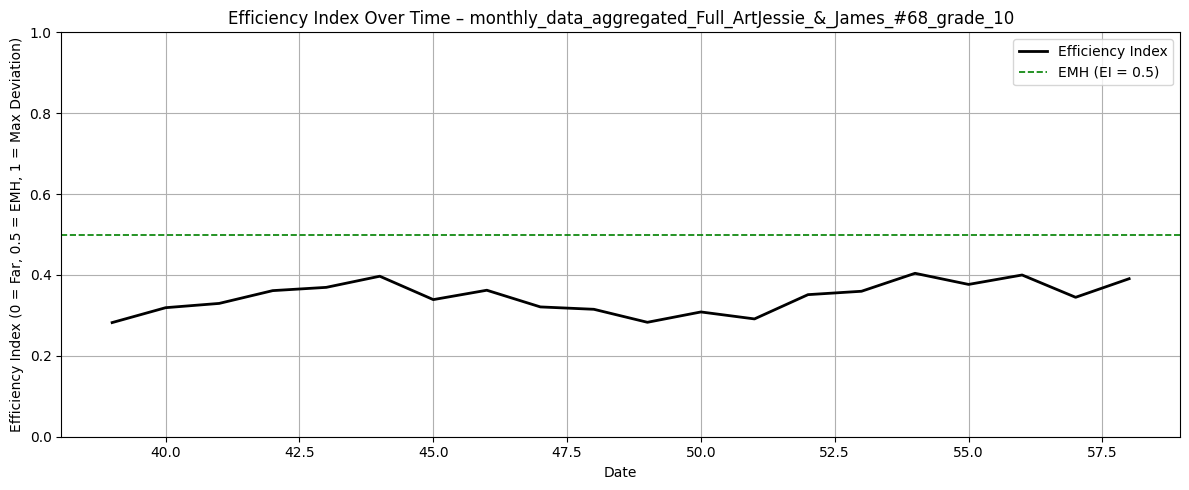

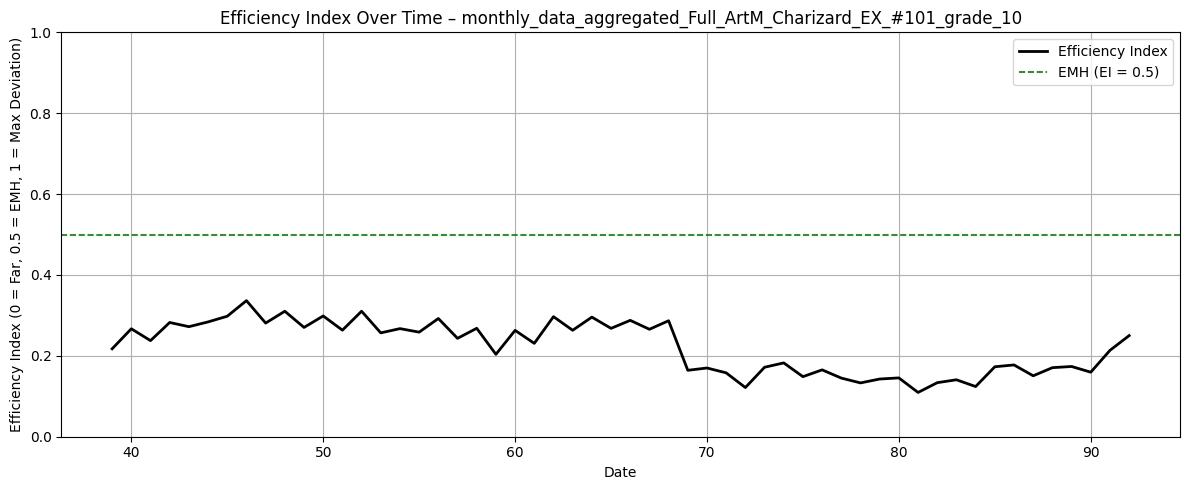

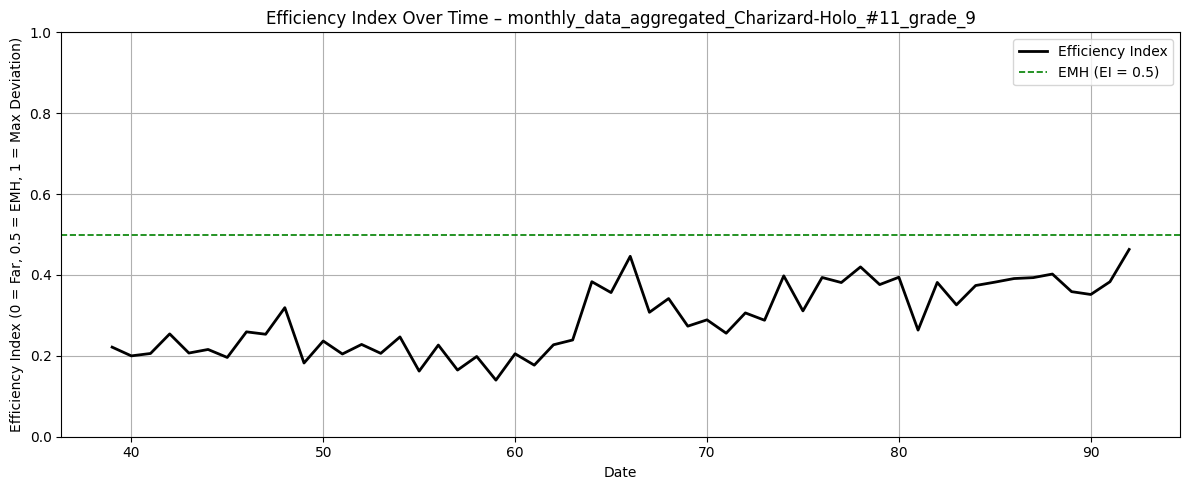

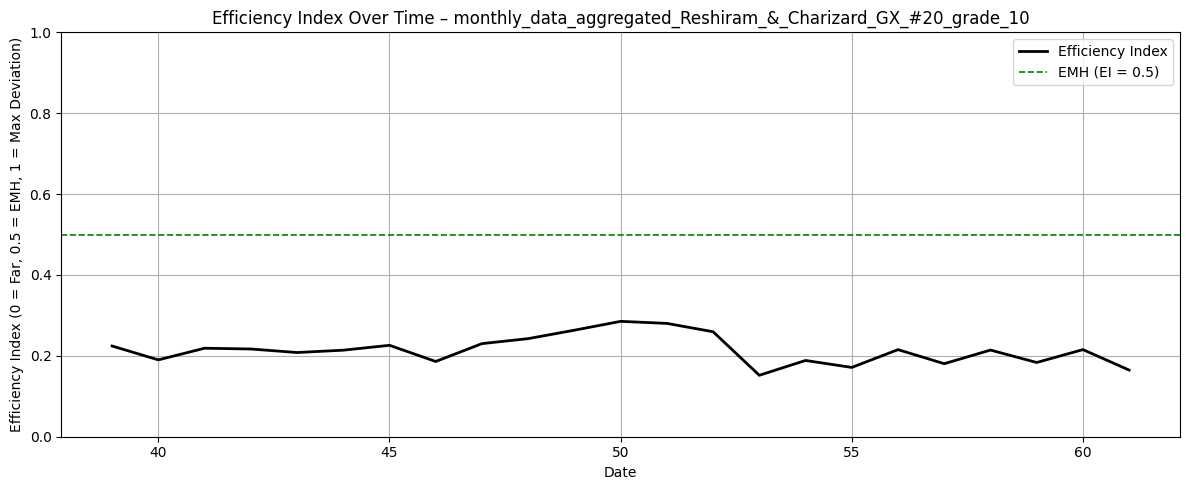

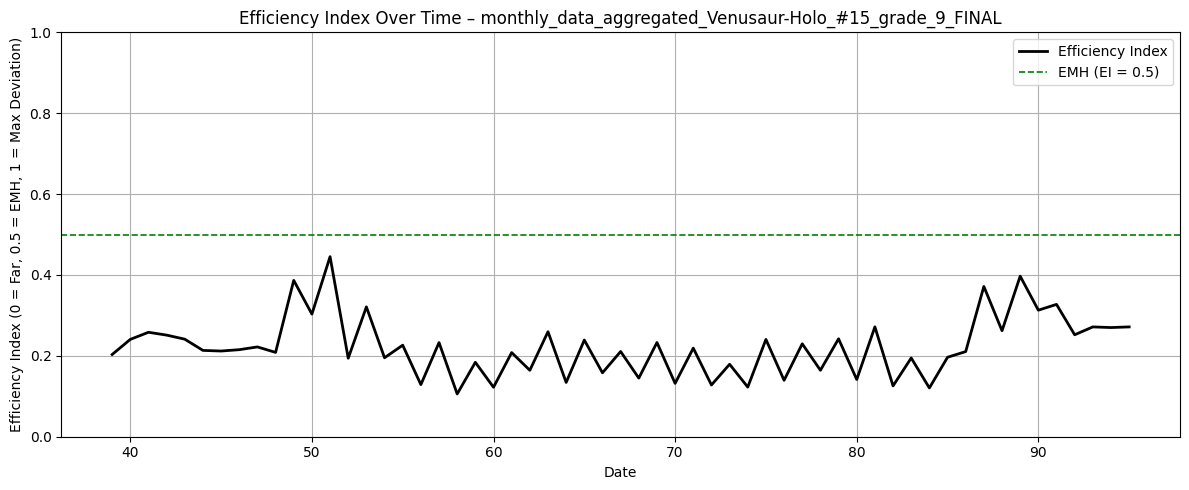

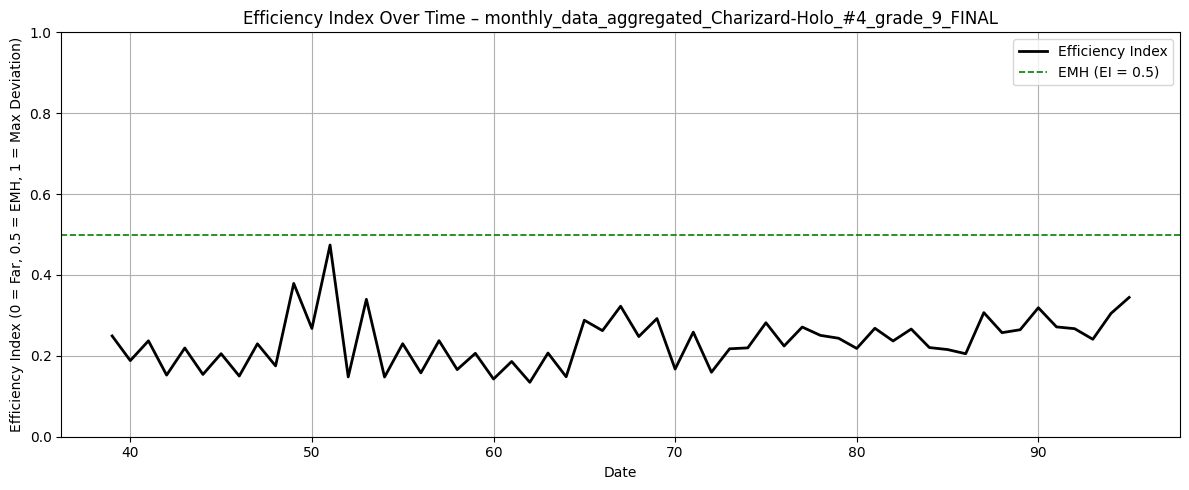

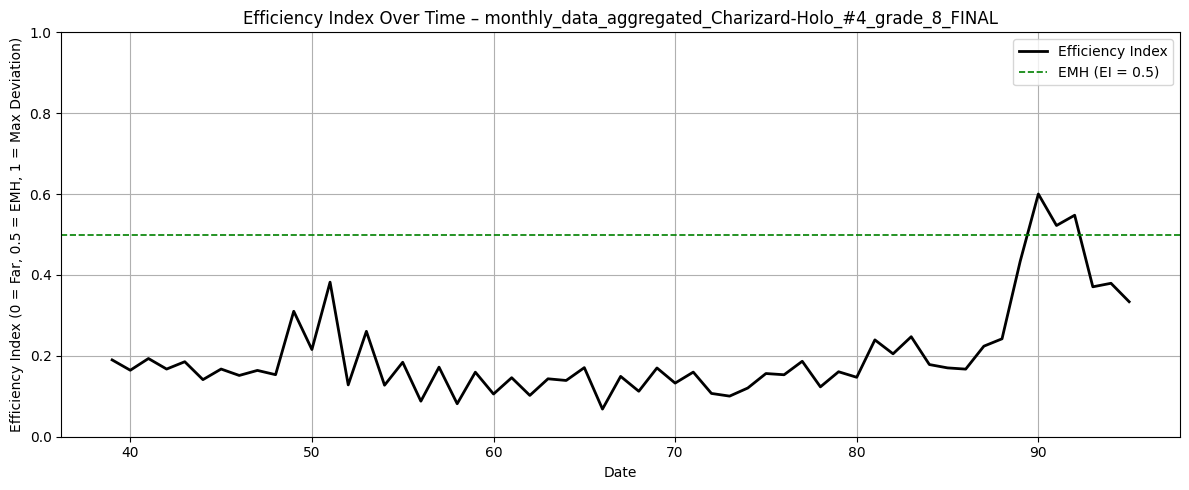

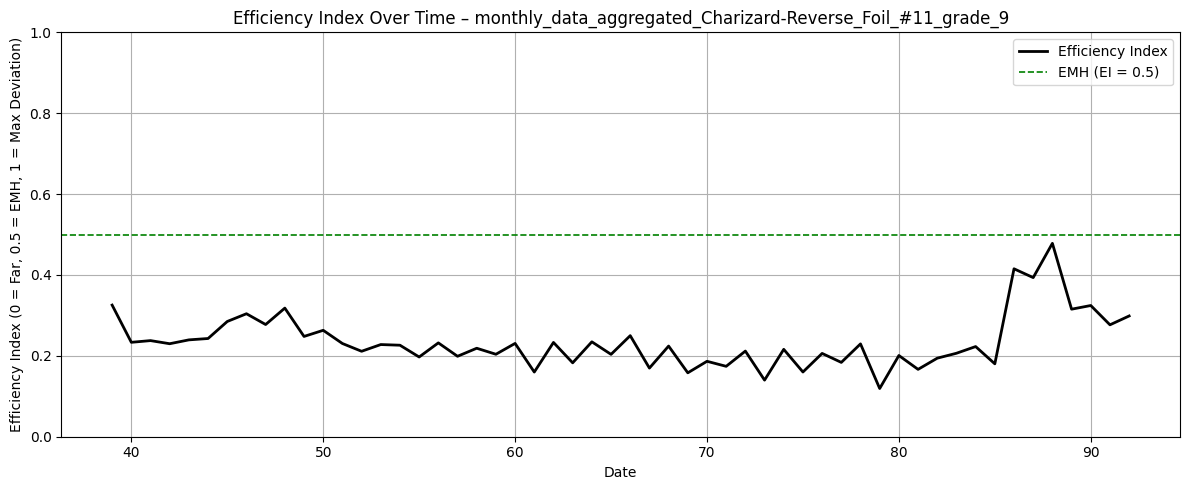

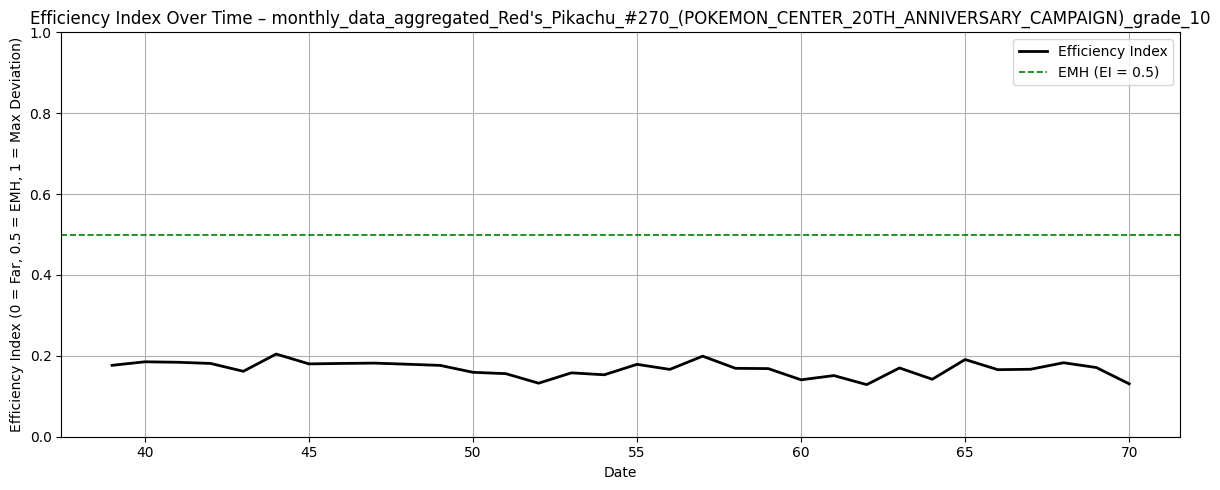

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_rolling_ei_only(log_returns, window_size=60, step=5, visualize=True, selected_cards=None):
    card_metrics_over_time = []

    # EMH center values and range normalization
    M_star = {"Hurst": 0.5, "Fractal_Dimension": 1.5, "Approx_Entropy": 1}
    R_values = {"Hurst": 1, "Fractal_Dimension": 1, "Approx_Entropy": 2}  # Assuming normalized scale for entropy

    for card, df in log_returns.items():
        series = df["Log_Returns"].dropna().values
        dates = df["Log_Returns"].dropna().index

        if len(series) < window_size:
            continue

        for i in range(0, len(series) - window_size + 1, step):
            window = series[i:i + window_size]
            date = dates[i + window_size - 1]

            # Compute core metrics
            metrics = {
                "Card": card,
                "Date": date,
                "Hurst_GPH": gph_estimator(pd.Series(window)),
                "Hurst_LW": local_whittle_estimator(pd.Series(window)),
                "Hall_Wood_FD": hall_wood_fd(pd.Series(window)),
                "Genton_FD": genton_fd(pd.Series(window)),
                "Approx_Entropy": approximate_entropy(pd.Series(window))
            }

            # Compute normalized Efficiency Index
            ei_vals = []
            for hurst in ["Hurst_GPH", "Hurst_LW"]:
                ei_vals.append(((metrics[hurst] - M_star["Hurst"]) / R_values["Hurst"])**2)
            for fd in ["Hall_Wood_FD", "Genton_FD"]:
                ei_vals.append(((metrics[fd] - M_star["Fractal_Dimension"]) / R_values["Fractal_Dimension"])**2)
            ei_vals.append(((metrics["Approx_Entropy"] - M_star["Approx_Entropy"]) / R_values["Approx_Entropy"])**2)

            ei_normalized = np.sqrt(sum(ei_vals)) / np.sqrt(len(ei_vals))  # Normalize to [0, 1]
            metrics["Efficiency_Index"] = ei_normalized

            card_metrics_over_time.append(metrics)

    # Create DataFrame
    rolling_df = pd.DataFrame(card_metrics_over_time)

    # Plot Efficiency Index only
    if visualize:
        cards_to_plot = selected_cards if selected_cards else rolling_df["Card"].unique()

        for card in cards_to_plot:
            subset = rolling_df[rolling_df["Card"] == card]
            if subset.empty:
                continue

            fig, ax = plt.subplots(figsize=(12, 5))
            subset.set_index("Date")["Efficiency_Index"].plot(ax=ax, color="black", lw=2, label="Efficiency Index")
            ax.axhline(0.5, color="green", linestyle="--", linewidth=1.2, label="EMH (EI = 0.5)")
            ax.set_ylim(0, 1)
            ax.set_title(f"Efficiency Index Over Time – {card}")
            ax.set_ylabel("Efficiency Index (0 = Far, 0.5 = EMH, 1 = Max Deviation)")
            ax.grid(True)
            ax.legend()
            plt.tight_layout()
            plt.show()

    return rolling_df


ei_df = compute_rolling_ei_only(
    log_returns,
    window_size=40,
    step=1,
    visualize=True,

)


# Now finally the efficiency index:

# !! USE THE FOLLOWING FOR EI - THE BEST CURATED:

In [ ]:
import numpy as np
import pandas as pd

# Expected values for an efficient market
M_star = {
    "Hurst": 0.5,
    "Fractal_Dimension": 1.5,
    "Approx_Entropy": 1.0
}

# Ranges for normalization
R_values = {
    "Hurst": 1.0,  # Hurst exponent range [0,1]
    "Fractal_Dimension": 1.0,  # Fractal dimension range [1,2]
    "Approx_Entropy": 2.0  # Entropy range as per Kristoufek & Vosvrda
}

# Load efficiency measures into a DataFrame (Assuming you have these DataFrames ready)
efficiency_data = pd.DataFrame({
    "Hurst_GPH": hurst_df_gph["Hurst_GPH"],  # GPH estimator
    "Hurst_LW": hurst_df_whittle["Hurst_LW"],  # Local Whittle estimator
    "Hall_Wood_FD": fractal_df["Hall_Wood_FD"],
    "Genton_FD": fractal_df["Genton_FD"],
    "Approx_Entropy": approx_entropy_df["Approx_Entropy"]
})

# Compute Efficiency Index (EI) function
def compute_efficiency_index(row):
    EI_values = []

    # Compute separately for both Hurst estimators (GPH & Local Whittle)
    for hurst in ["Hurst_GPH", "Hurst_LW"]:
        EI_values.append(((row[hurst] - M_star["Hurst"]) / R_values["Hurst"])**2)

    # Compute separately for both Fractal Dimension estimators
    for fd in ["Hall_Wood_FD", "Genton_FD"]:
        EI_values.append(((row[fd] - M_star["Fractal_Dimension"]) / R_values["Fractal_Dimension"])**2)

    # Compute for Approximate Entropy
    EI_values.append(((row["Approx_Entropy"] - M_star["Approx_Entropy"]) / R_values["Approx_Entropy"])**2)

    # Final Efficiency Index calculation
    return np.sqrt(sum(EI_values))

# Apply function to all rows
efficiency_data["Efficiency_Index"] = efficiency_data.apply(compute_efficiency_index, axis=1)

efficiency_data

Hurst_GPH  Hurst_LW  \
monthly_data_aggregated_Full_ArtJessie_&_James_...   0.535019  0.232604   
monthly_data_aggregated_Venusaur-Holo_#15_grade...   0.711170  0.486646   
monthly_data_aggregated_Charizard-Holo_#11_grade_9   0.725738  0.391737   
monthly_data_aggregated_Charizard-Holo_#4_grade...   0.564224  0.473980   
monthly_data_aggregated_Charizard-Reverse_Foil_...   0.646469  0.457306   
monthly_data_aggregated_Charizard-Holo_#4_grade...   0.615865  0.424427   
monthly_data_aggregated_Reshiram_&_Charizard_GX...   0.424688  0.335857   
monthly_data_aggregated_Red's_Pikachu_#270_(POK...   0.604148  0.562663   
monthly_data_aggregated_Full_ArtM_Charizard_EX_...   0.650737  0.471069   

                                                    Hall_Wood_FD  Genton_FD  \
monthly_data_aggregated_Full_ArtJessie_&_James_...      1.791974   1.943319   
monthly_data_aggregated_Venusaur-Holo_#15_grade...      1.878121   1.866516   
monthly_data_aggregated_Charizard-Holo_#11_grade_9      1.857317   1.912792   
monthly_data_aggregated_Charizard-Holo_#4_grade...      1.891009   1.872086   
monthly_data_aggregated_Charizard-Reverse_Foil_...      1.941555   1.815142   
monthly_data_aggregated_Charizard-Holo_#4_grade...      1.845175   1.893031   
monthly_data_aggregated_Reshiram_&_Charizard_GX...      1.863206   1.805315   
monthly_data_aggregated_Red's_Pikachu_#270_(POK...      1.670549   1.813097   
monthly_data_aggregated_Full_ArtM_Charizard_EX_...      1.758632   1.817517   

                                                    Approx_Entropy  \
monthly_data_aggregated_Full_ArtJessie_&_James_...        1.278124   
monthly_data_aggregated_Venusaur-Holo_#15_grade...        1.116615   
monthly_data_aggregated_Charizard-Holo_#11_grade_9        1.146083   
monthly_data_aggregated_Charizard-Holo_#4_grade...        1.172723   
monthly_data_aggregated_Charizard-Reverse_Foil_...        1.079883   
monthly_data_aggregated_Charizard-Holo_#4_grade...        1.051609   
monthly_data_aggregated_Reshiram_&_Charizard_GX...        0.861378   
monthly_data_aggregated_Red's_Pikachu_#270_(POK...        1.026561   
monthly_data_aggregated_Full_ArtM_Charizard_EX_...        1.132805   

                                                    Efficiency_Index  
monthly_data_aggregated_Full_ArtJessie_&_James_...          0.611430  
monthly_data_aggregated_Venusaur-Holo_#15_grade...          0.570509  
monthly_data_aggregated_Charizard-Holo_#11_grade_9          0.605051  
monthly_data_aggregated_Charizard-Holo_#4_grade...          0.550996  
monthly_data_aggregated_Charizard-Reverse_Foil_...          0.564940  
monthly_data_aggregated_Charizard-Holo_#4_grade...          0.541684  
monthly_data_aggregated_Reshiram_&_Charizard_GX...          0.512401  
monthly_data_aggregated_Red's_Pikachu_#270_(POK...          0.376917  
monthly_data_aggregated_Full_ArtM_Charizard_EX_...          0.442352

## top functioning bootstrap (just wait 30 mins:):

In [ ]:
import numpy as np
import pandas as pd

# Function to compute the Efficiency Index
def compute_efficiency_index(row, M_star, R_values):
    EI_values = []

    # Compute for both Hurst exponents
    for hurst in ["Hurst_GPH", "Hurst_LW"]:
        EI_values.append(((row[hurst] - M_star["Hurst"]) / R_values["Hurst"])**2)

    # Compute for both Fractal Dimensions
    for fd in ["Hall_Wood_FD", "Genton_FD"]:
        EI_values.append(((row[fd] - M_star["Fractal_Dimension"]) / R_values["Fractal_Dimension"])**2)

    # Compute for Approximate Entropy
    EI_values.append(((row["Approx_Entropy"] - M_star["Approx_Entropy"]) / R_values["Approx_Entropy"])**2)

    return np.sqrt(sum(EI_values))

# Define expected values and ranges for efficiency measures
M_star = {"Hurst": 0.5, "Fractal_Dimension": 1.5, "Approx_Entropy": 1}
R_values = {"Hurst": 1, "Fractal_Dimension": 1, "Approx_Entropy": 2}  # Entropy range is double

# Step 1: Compute original Efficiency Index
efficiency_data["Efficiency_Index"] = efficiency_data.apply(compute_efficiency_index, axis=1, M_star=M_star, R_values=R_values)

# Function to perform bootstrapping for a given card
def bootstrap_efficiency(log_returns, num_bootstraps=1000):
    n = len(log_returns)
    bootstrap_EI = []

    for _ in range(num_bootstraps):
        # Step 2: Generate a bootstrapped sample with replacement
        bootstrapped_series = np.random.choice(log_returns, size=n, replace=True)

        # Step 3: Compute Efficiency Index for bootstrapped series
        bootstrapped_measures = {
            "Hurst_GPH": gph_estimator(pd.Series(bootstrapped_series)),
            "Hurst_LW": local_whittle_estimator(pd.Series(bootstrapped_series)),
            "Hall_Wood_FD": hall_wood_fd(pd.Series(bootstrapped_series)),
            "Genton_FD": genton_fd(pd.Series(bootstrapped_series)),
            "Approx_Entropy": approximate_entropy(pd.Series(bootstrapped_series))
        }
        bootstrapped_EI = compute_efficiency_index(bootstrapped_measures, M_star, R_values)
        bootstrap_EI.append(bootstrapped_EI)

    return bootstrap_EI

# Apply bootstrapping to all cards
bootstrap_results = {}
for card, df in log_returns.items():
    bootstrap_EI_values = bootstrap_efficiency(df["Log_Returns"])

    # Step 5: Compute statistical significance
    q05, q95 = np.percentile(bootstrap_EI_values, [5, 95])
    original_EI = efficiency_data.loc[card, "Efficiency_Index"]

    # Compute p-value based on rank of original EI
    r = sum(bootstrap_EI_values < original_EI) + 1  # Rank of original EI
    p_value = 1 - 2 * abs(r / (len(bootstrap_EI_values) + 1) - 0.5)

    # Store results
    bootstrap_results[card] = {
        "EI": original_EI,
        "EI_Boot_Mean": np.mean(bootstrap_EI_values),
        "EI_Boot_SD": np.std(bootstrap_EI_values),
        "q05": q05,
        "q95": q95,
        "p_value": p_value
    }

# Convert results to DataFrame
bootstrap_results_df = pd.DataFrame.from_dict(bootstrap_results, orient="index")
bootstrap_results_df

EI  EI_Boot_Mean  \
monthly_data_aggregated_Full_ArtJessie_&_James_...  0.611430      0.581213   
monthly_data_aggregated_Venusaur-Holo_#15_grade...  0.570509      0.475996   
monthly_data_aggregated_Charizard-Holo_#11_grade_9  0.605051      0.497250   
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.550996      0.492415   
monthly_data_aggregated_Charizard-Reverse_Foil_...  0.564940      0.415412   
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.541684      0.483810   
monthly_data_aggregated_Reshiram_&_Charizard_GX...  0.512401      0.472116   
monthly_data_aggregated_Red's_Pikachu_#270_(POK...  0.376917      0.497013   
monthly_data_aggregated_Full_ArtM_Charizard_EX_...  0.442352      0.471018   

                                                    EI_Boot_SD       q05  \
monthly_data_aggregated_Full_ArtJessie_&_James_...    0.149618  0.351218   
monthly_data_aggregated_Venusaur-Holo_#15_grade...    0.072252  0.357950   
monthly_data_aggregated_Charizard-Holo_#11_grade_9    0.070422  0.381081   
monthly_data_aggregated_Charizard-Holo_#4_grade...    0.073295  0.377984   
monthly_data_aggregated_Charizard-Reverse_Foil_...    0.070533  0.300538   
monthly_data_aggregated_Charizard-Holo_#4_grade...    0.072406  0.375056   
monthly_data_aggregated_Reshiram_&_Charizard_GX...    0.098560  0.320475   
monthly_data_aggregated_Red's_Pikachu_#270_(POK...    0.102679  0.341121   
monthly_data_aggregated_Full_ArtM_Charizard_EX_...    0.073163  0.360213   

                                                         q95   p_value  
monthly_data_aggregated_Full_ArtJessie_&_James_...  0.839313  0.823177  
monthly_data_aggregated_Venusaur-Holo_#15_grade...  0.597328  0.183816  
monthly_data_aggregated_Charizard-Holo_#11_grade_9  0.611658  0.107892  
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.616652  0.393606  
monthly_data_aggregated_Charizard-Reverse_Foil_...  0.528401  0.031968  
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.608083  0.425574  
monthly_data_aggregated_Reshiram_&_Charizard_GX...  0.635251  0.663337  
monthly_data_aggregated_Red's_Pikachu_#270_(POK...  0.667107  0.237762  
monthly_data_aggregated_Full_ArtM_Charizard_EX_...  0.596045  0.701299

In [ ]:
# Compute the alternative inefficiency measure (distance in SDs)
bootstrap_results_df["↑distance↑"] = (
    abs(bootstrap_results_df["EI"] - bootstrap_results_df["EI_Boot_Mean"]) /
    bootstrap_results_df["EI_Boot_SD"]
)

# Sort by highest inefficiency (most inefficient cards first)
bootstrap_results_df = bootstrap_results_df.sort_values(by="↑distance↑", ascending=True)


bootstrap_results_df

EI  EI_Boot_Mean  \
monthly_data_aggregated_Full_ArtJessie_&_James_...  0.611430      0.581213   
monthly_data_aggregated_Full_ArtM_Charizard_EX_...  0.442352      0.471018   
monthly_data_aggregated_Reshiram_&_Charizard_GX...  0.512401      0.472116   
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.550996      0.492415   
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.541684      0.483810   
monthly_data_aggregated_Red's_Pikachu_#270_(POK...  0.376917      0.497013   
monthly_data_aggregated_Venusaur-Holo_#15_grade...  0.570509      0.475996   
monthly_data_aggregated_Charizard-Holo_#11_grade_9  0.605051      0.497250   
monthly_data_aggregated_Charizard-Reverse_Foil_...  0.564940      0.415412   

                                                    EI_Boot_SD       q05  \
monthly_data_aggregated_Full_ArtJessie_&_James_...    0.149618  0.351218   
monthly_data_aggregated_Full_ArtM_Charizard_EX_...    0.073163  0.360213   
monthly_data_aggregated_Reshiram_&_Charizard_GX...    0.098560  0.320475   
monthly_data_aggregated_Charizard-Holo_#4_grade...    0.073295  0.377984   
monthly_data_aggregated_Charizard-Holo_#4_grade...    0.072406  0.375056   
monthly_data_aggregated_Red's_Pikachu_#270_(POK...    0.102679  0.341121   
monthly_data_aggregated_Venusaur-Holo_#15_grade...    0.072252  0.357950   
monthly_data_aggregated_Charizard-Holo_#11_grade_9    0.070422  0.381081   
monthly_data_aggregated_Charizard-Reverse_Foil_...    0.070533  0.300538   

                                                         q95   p_value  \
monthly_data_aggregated_Full_ArtJessie_&_James_...  0.839313  0.823177   
monthly_data_aggregated_Full_ArtM_Charizard_EX_...  0.596045  0.701299   
monthly_data_aggregated_Reshiram_&_Charizard_GX...  0.635251  0.663337   
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.616652  0.393606   
monthly_data_aggregated_Charizard-Holo_#4_grade...  0.608083  0.425574   
monthly_data_aggregated_Red's_Pikachu_#270_(POK...  0.667107  0.237762   
monthly_data_aggregated_Venusaur-Holo_#15_grade...  0.597328  0.183816   
monthly_data_aggregated_Charizard-Holo_#11_grade_9  0.611658  0.107892   
monthly_data_aggregated_Charizard-Reverse_Foil_...  0.528401  0.031968   

                                                    ↑distance↑  
monthly_data_aggregated_Full_ArtJessie_&_James_...    0.201959  
monthly_data_aggregated_Full_ArtM_Charizard_EX_...    0.391810  
monthly_data_aggregated_Reshiram_&_Charizard_GX...    0.408734  
monthly_data_aggregated_Charizard-Holo_#4_grade...    0.799245  
monthly_data_aggregated_Charizard-Holo_#4_grade...    0.799285  
monthly_data_aggregated_Red's_Pikachu_#270_(POK...    1.169635  
monthly_data_aggregated_Venusaur-Holo_#15_grade...    1.308107  
monthly_data_aggregated_Charizard-Holo_#11_grade_9    1.530784  
monthly_data_aggregated_Charizard-Reverse_Foil_...    2.119983

 Next Steps for Further Analysis

Compare Inefficient Cards to Trading Volume

    Do the most inefficient cards have the lowest liquidity?
    Does high inefficiency correlate with low sales activity?

Visualize Price Trajectories of Inefficient Cards

    Do the most inefficient cards have erratic price spikes & drops?
    If so, that confirms inefficiency.

Check If Inefficiency Persists Over Time

    Run the same bootstrapping analysis on monthly data.
    If inefficiency disappears, markets may be inefficient in the short term but efficient in the long run.